In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from utils import (
    get_runs, get_enemies_by_run_id, get_enemies_by_run_indexes, get_obstacles_by_run_id, get_obstacles_by_run_indexes,
    plot_for_each_level,
    enemy_names, enemy_weights, obstacle_names, obstacle_weights,
    name_mapping, enemy_name_map, obstacle_name_map,
    level_cost, feedback_order, feedback_mapping
)

In [2]:
runs = get_runs()

In [3]:
folder_path = './figs/objects_analysis/'

# Análise de Hits

Pergunta de pesquisa: "Como os hits dos inimigos influenciam o desempenho e a percepção de dificuldade dos jogadores?"

## Funções Comuns

In [4]:
def get_level_damage_data(df):
	damage_data = []

	for level in df['level'].unique():
		df_level = df[df['level'] == level]

		data = {name: 0 for name in enemy_names}
		enemies = get_enemies_by_run_indexes(df_level['id'])

		for _, row in enemies.iterrows():
			name = row['nome']
			damage_value = row['damage_value']
			data[name] += damage_value

		total_damage = sum(data[name] for name in enemy_names)

		damage_data.append({
			'Level': level,
			'Enemy1': data['Enemy1'] / total_damage if total_damage > 0 else 0,
			'Enemy2': data['Enemy2'] / total_damage if total_damage > 0 else 0,
			'Enemy3': data['Enemy3'] / total_damage if total_damage > 0 else 0,
		})

	damage_df = pd.DataFrame(damage_data)
	return damage_df

In [5]:
def get_feedback_damage_data(df):
	damage_data = []

	for difficulty in df['player_feedback'].unique():
		filtered_df = df[df['player_feedback'] == difficulty]

		data = {name: 0 for name in enemy_names}
		enemies = get_enemies_by_run_indexes(filtered_df['id'])

		for _, row in enemies.iterrows():
			name = row['nome']
			damage_value = row['damage_value']
			data[name] += damage_value

		total_damage = sum(data[name] for name in enemy_names)
		damage_data.append({
			'feedback': difficulty,
			'Enemy1': data['Enemy1'] / total_damage if total_damage > 0 else 0,
			'Enemy2': data['Enemy2'] / total_damage if total_damage > 0 else 0,
			'Enemy3': data['Enemy3'] / total_damage if total_damage > 0 else 0,
		})

	df_damage = pd.DataFrame(damage_data)
	return df_damage

## Proporção de Dano dos Inimigos por Nível

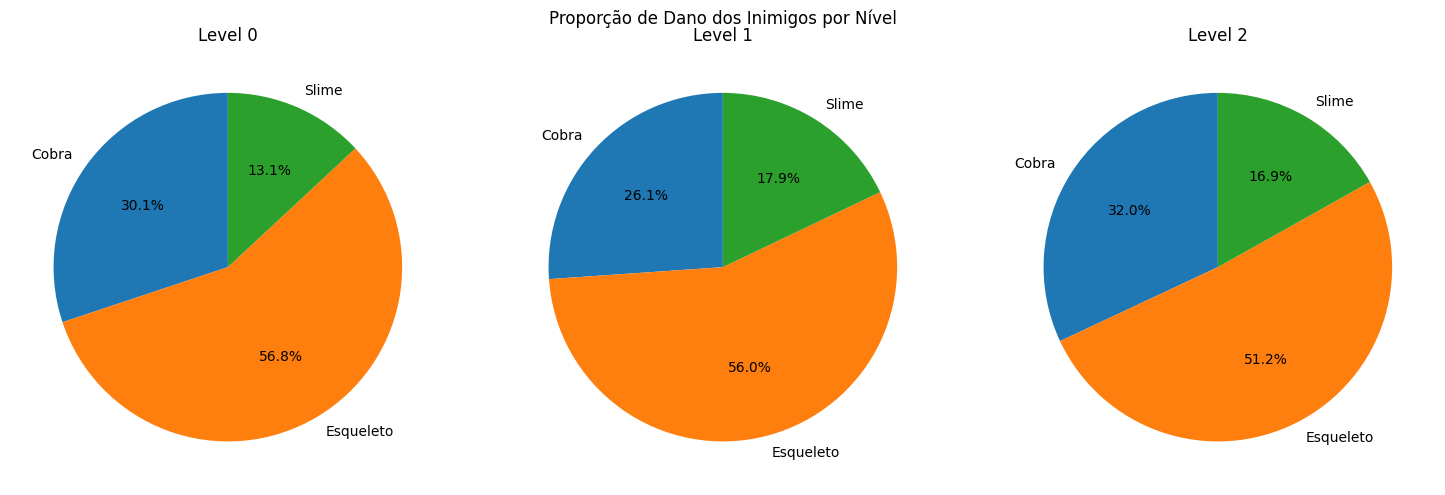

In [6]:
damage_df = get_level_damage_data(runs)

levels = damage_df['Level'].unique()
num_levels = len(levels)

fig, axes = plt.subplots(1, num_levels, figsize=(num_levels * 5, 5))

for i, level in enumerate(levels):
	df_level = damage_df[damage_df['Level'] == level].drop(columns=['Level'])

	damage_totals = df_level.sum(axis=1)
	damage_proportions = df_level.div(damage_totals, axis=0).values.flatten()

	labels = df_level.columns
	transformed_labels = [enemy_name_map.get(label, label) for label in labels]

	axes[i].pie(damage_proportions, labels=transformed_labels, autopct='%1.1f%%', startangle=90)
	axes[i].set_title(f'Level {level}')

plt.suptitle('Proporção de Dano dos Inimigos por Nível')
plt.savefig(f'{folder_path}/enemies_damage.png', dpi=96, bbox_inches='tight')
plt.tight_layout()
plt.show()

## Proporção de Dano dos Inimigos por Feedback

### Um plot por nível

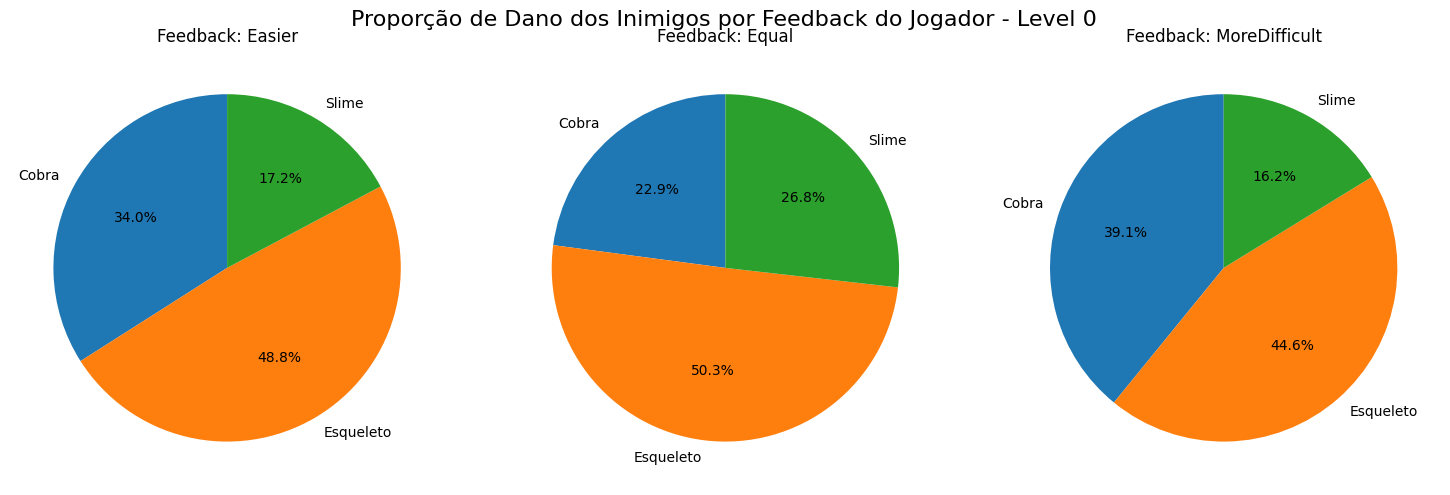

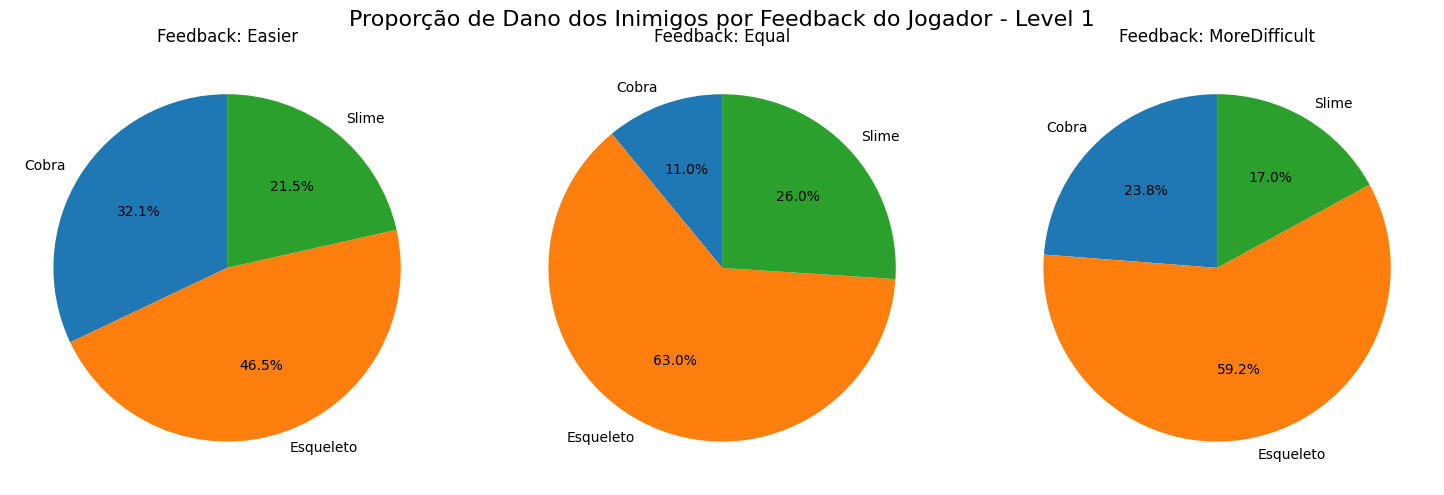

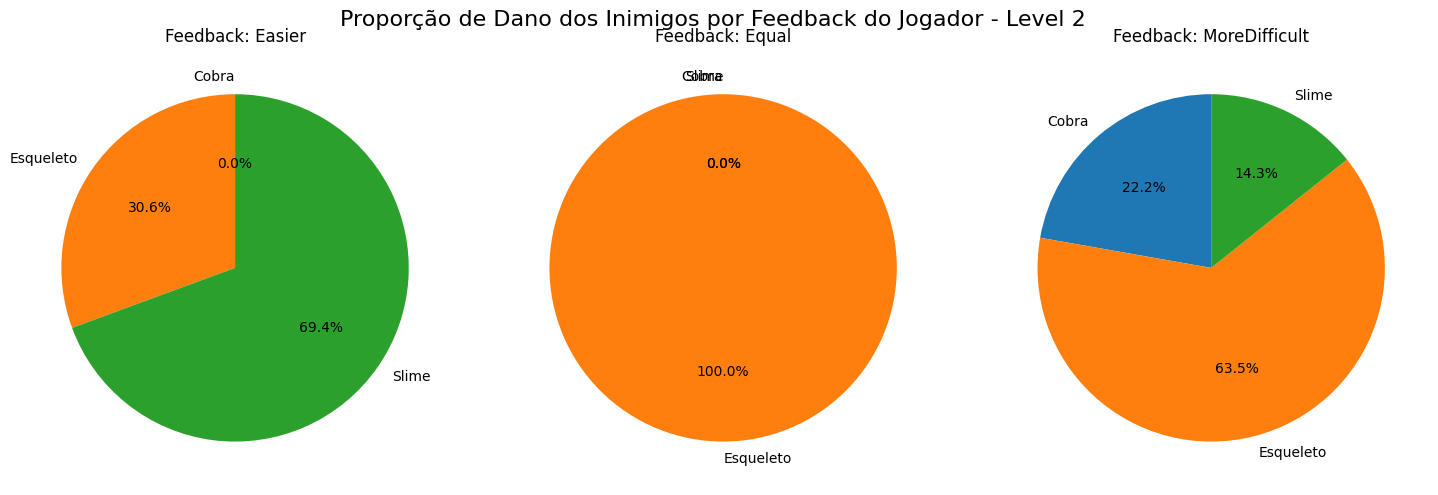

In [7]:
def plot_enemy_damage_by_feedback(df, level=None):
    df_damage = get_feedback_damage_data(df)
    difficulties = df_damage['feedback'].unique()

    fig, axes = plt.subplots(1, len(difficulties), figsize=(len(difficulties) * 5, 5))

    if len(difficulties) == 1:
        axes = [axes]

    for i, difficulty in enumerate(feedback_order):
        df_difficulty = df_damage[df_damage['feedback'] == difficulty]
        proportions = df_difficulty[enemy_names].sum()
        labels = enemy_names

        transformed_labels = [enemy_name_map.get(label, label) for label in labels]

        axes[i].pie(proportions, labels=transformed_labels, autopct='%1.1f%%', startangle=90)
        axes[i].set_title(f'Feedback: {difficulty}')

    if level is not None:
        plt.suptitle(f'Proporção de Dano dos Inimigos por Feedback do Jogador - Level {level}', fontsize=16)
        plt.savefig(f'{folder_path}/enemies_damage_feedback_level_{level}.png', dpi=96, bbox_inches='tight')
    else:
        plt.suptitle('Proporção de Dano dos Inimigos por Feedback do Jogador', fontsize=16)
        plt.savefig(f'{folder_path}/enemies_damage_feedback.png', dpi=96, bbox_inches='tight')

    plt.tight_layout()
    plt.show()

filtered_runs = runs[runs['player_feedback'] != '']
plot_for_each_level(filtered_runs, plot_enemy_damage_by_feedback)

### Em um plot só

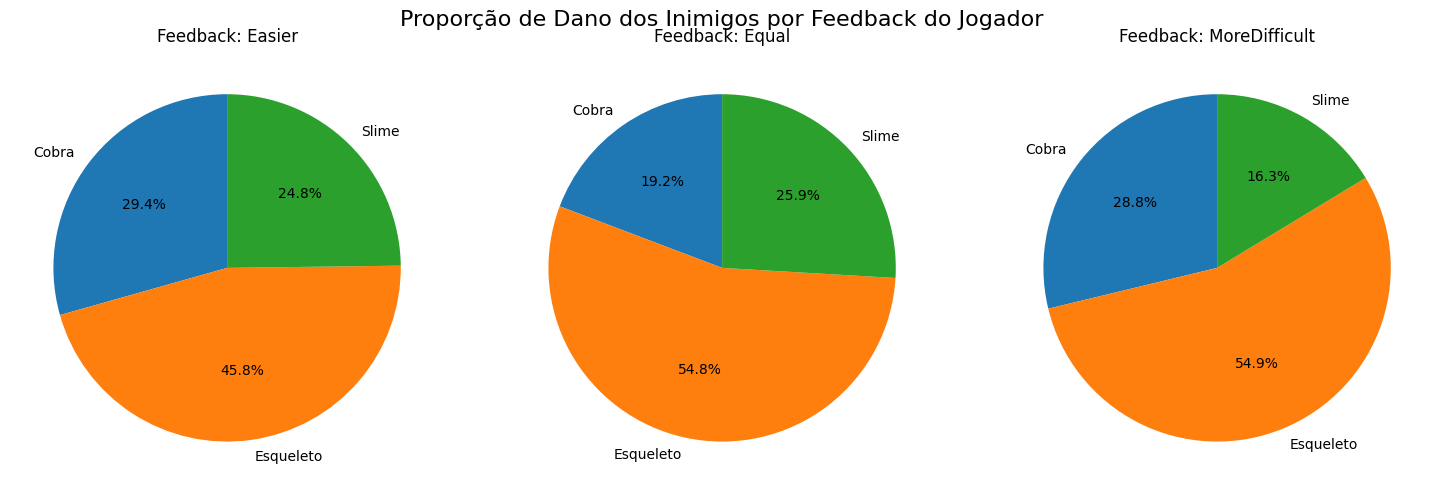

In [8]:
plot_enemy_damage_by_feedback(filtered_runs)

# Análise de balanceamento entre inimigos e obstáculos

Pergunta de pesquisa: "Como a combinação de inimigos e obstáculos impacta a dificuldade percebida e o desempenho dos jogadores?"

Pergunta de pesquisa: "Quais tipos de inimigos e obstáculos aparecem mais frequentemente em níveis difíceis comparados a níveis fáceis?"

Pergunta de pesquisa: "O número de inimigos e obstáculos influencia o feedback dos jogadores sobre a dificuldade?"

### Frequência de inimigos e obstáculos x feedback

#### Funções comuns

In [9]:
def get_object_costs_by_feedback(df):
    data = []

    for feedback in feedback_order:
        filtered_df = df[df['player_feedback'] == feedback]

        for _, row in filtered_df.iterrows():
            costs = {name: 0 for name in enemy_names + obstacle_names}

            enemies = get_enemies_by_run_id(row['id'])
            obstacles = get_obstacles_by_run_id(row['id'])

            for _, row in enemies.iterrows():
                name = row['nome']
                quantity = row['quantity']

                cost = enemy_weights[name] * quantity
                costs[name] += cost

            for _, row in obstacles.iterrows():
                name = row['nome']
                quantity = row['quantity']

                cost = obstacle_weights[name] * quantity
                costs[name] += cost
            
            data.append({'Feedback': feedback, **costs})

    df_costs = pd.DataFrame(data)
    return df_costs

In [10]:
def print_pie_charts(df_costs, level=None):
    fig, axes = plt.subplots(1, len(feedback_order), figsize=(15, 5))
    for i, difficulty in enumerate(feedback_order):
        df_filtered = df_costs[df_costs['Feedback'] == difficulty]
        
        total_costs = df_filtered[['Enemy1', 'Enemy2', 'Enemy3']].sum()

        transformed_labels = [enemy_name_map.get(label, label) for label in total_costs.index]
        axes[i].pie(total_costs, labels=transformed_labels, autopct='%1.1f%%', startangle=90)
        axes[i].set_title(f'Inimigos - {difficulty}')
        axes[i].axis('equal')

    if level is not None:
        plt.suptitle(f'Proporção de Custos dos Inimigos no Level {level}', fontsize=16)
        plt.savefig(f'{folder_path}/enemies_cost_distribution_level_{level}.png', dpi=96, bbox_inches='tight')
    else:
        plt.suptitle('Proporção de Custos dos Inimigos', fontsize=16)
        plt.savefig(f'{folder_path}/enemies_cost_distribution.png', dpi=96, bbox_inches='tight')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    fig, axes = plt.subplots(1, len(feedback_order), figsize=(15, 5))
    for i, difficulty in enumerate(feedback_order):
        df_filtered = df_costs[df_costs['Feedback'] == difficulty]
        total_costs = df_filtered[['Obstacle1', 'Obstacle2']].sum()

        transformed_labels = [obstacle_name_map.get(label, label) for label in total_costs.index]
        
        axes[i].pie(total_costs, labels=transformed_labels, autopct='%1.1f%%', startangle=90)
        axes[i].set_title(f'Obstáculos - {difficulty}')
        axes[i].axis('equal')

    if level is not None:
        plt.suptitle(f'Proporção de Custos dos Obstáculos no Level {level}', fontsize=16)
        plt.savefig(f'{folder_path}/obstacles_cost_distribution_level_{level}.png', dpi=96, bbox_inches='tight')
    else:
        plt.suptitle('Proporção de Custos dos Obstáculos', fontsize=16)
        plt.savefig(f'{folder_path}/obstacles_cost_distribution.png', dpi=96, bbox_inches='tight')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [11]:
def normalize_by_row(df):
    return df.div(df.sum(axis=1), axis=0)

def print_correlations_normalized(df_costs, level=None):
    df_enemies = df_costs[['Enemy1', 'Enemy2', 'Enemy3']]
    df_obstacles = df_costs[['Obstacle1', 'Obstacle2']]
    
    df_enemies_normalized = normalize_by_row(df_enemies)
    df_obstacles_normalized = normalize_by_row(df_obstacles)
    
    df_enemies_normalized['Feedback'] = df_costs['Feedback'].map(feedback_mapping)
    df_obstacles_normalized['Feedback'] = df_costs['Feedback'].map(feedback_mapping)
    
    combined_df = pd.concat([df_enemies_normalized, df_obstacles_normalized], axis=1)
    combined_correlation_matrix = combined_df.corr()
    combined_correlation_matrix.rename(index=name_mapping, columns=name_mapping, inplace=True)

    print(combined_correlation_matrix['Feedback'])

    plt.figure(figsize=(10, 8))
    sns.heatmap(combined_correlation_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)

    if level is not None:
        plt.title(f"Heatmap de Correlação (Normalizado) entre Dificuldade, Custos dos Inimigos e Obstáculos no Level {level}")
        plt.savefig(f'{folder_path}/correlation_object_cost_feedback_level_{level}.png', dpi=96, bbox_inches='tight')
    else:
        plt.title("Heatmap de Correlação (Normalizado) entre Dificuldade, Custos dos Inimigos e Obstáculos")
        plt.savefig(f'{folder_path}/correlation_object_cost_feedback.png', dpi=96, bbox_inches='tight')

    plt.show()

#### Um plot por nível

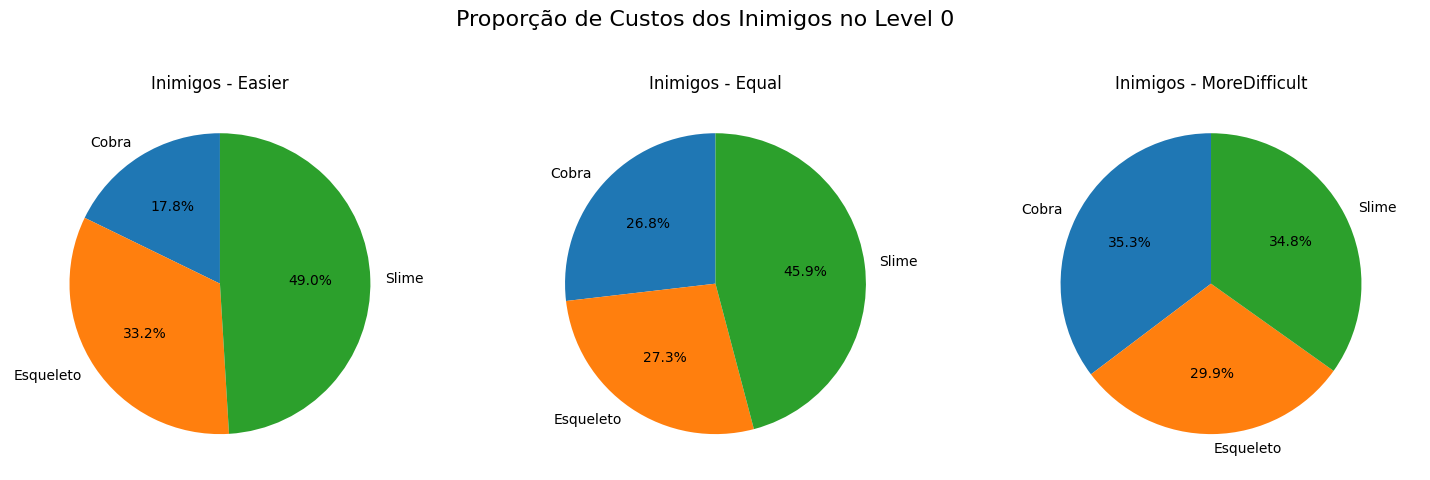

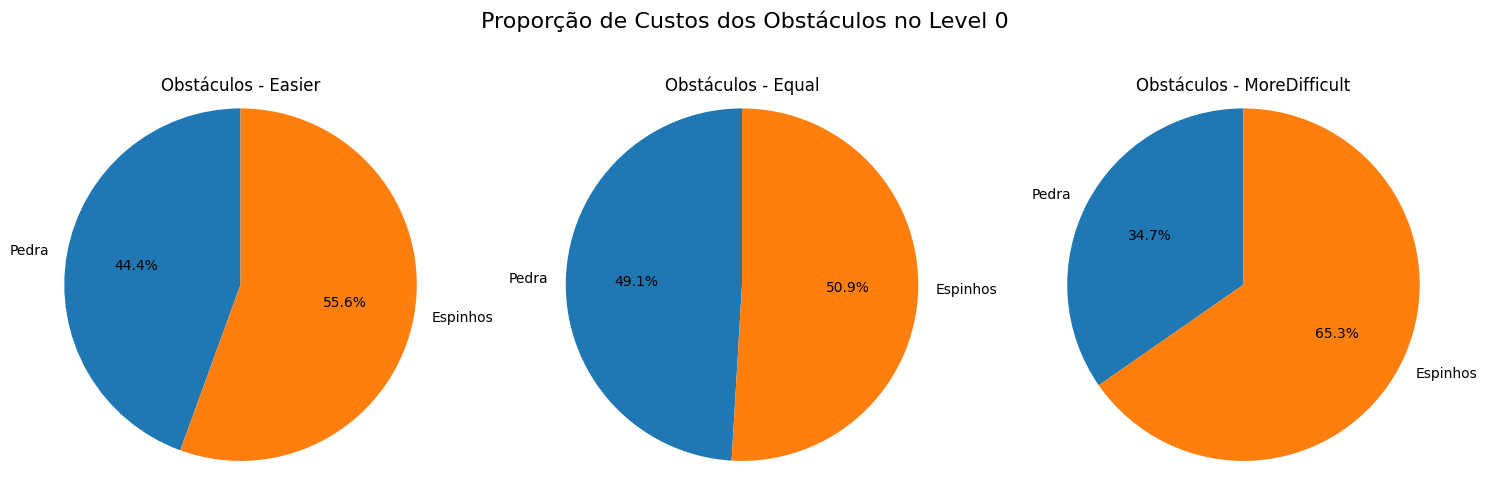

           Feedback  Feedback
Cobra      0.183645  0.183645
Esqueleto -0.012894 -0.012894
Slime     -0.145668 -0.145668
Feedback   1.000000  1.000000
Pedra     -0.120659 -0.120659
Espinhos   0.120659  0.120659
Feedback   1.000000  1.000000


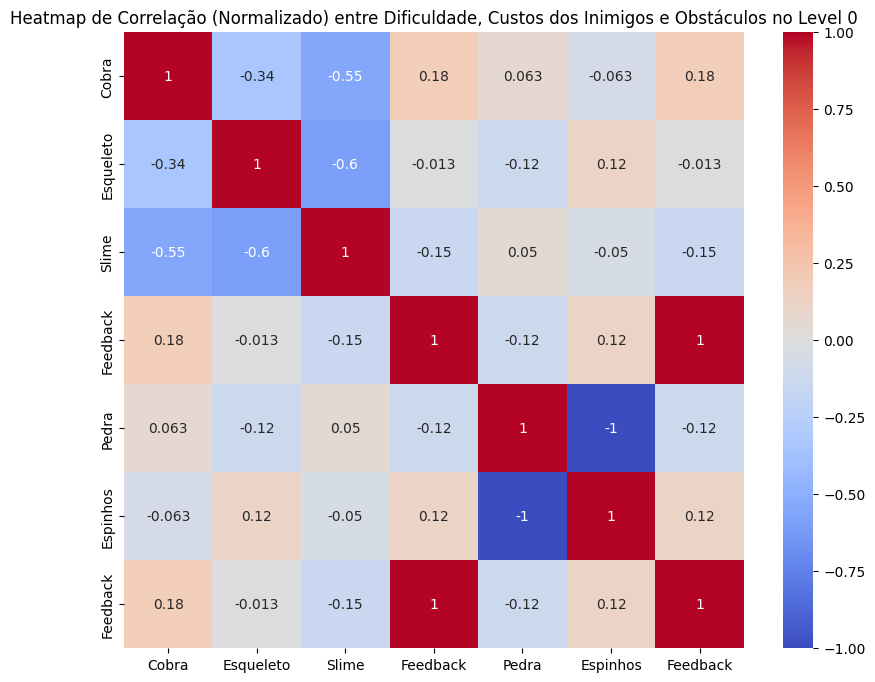

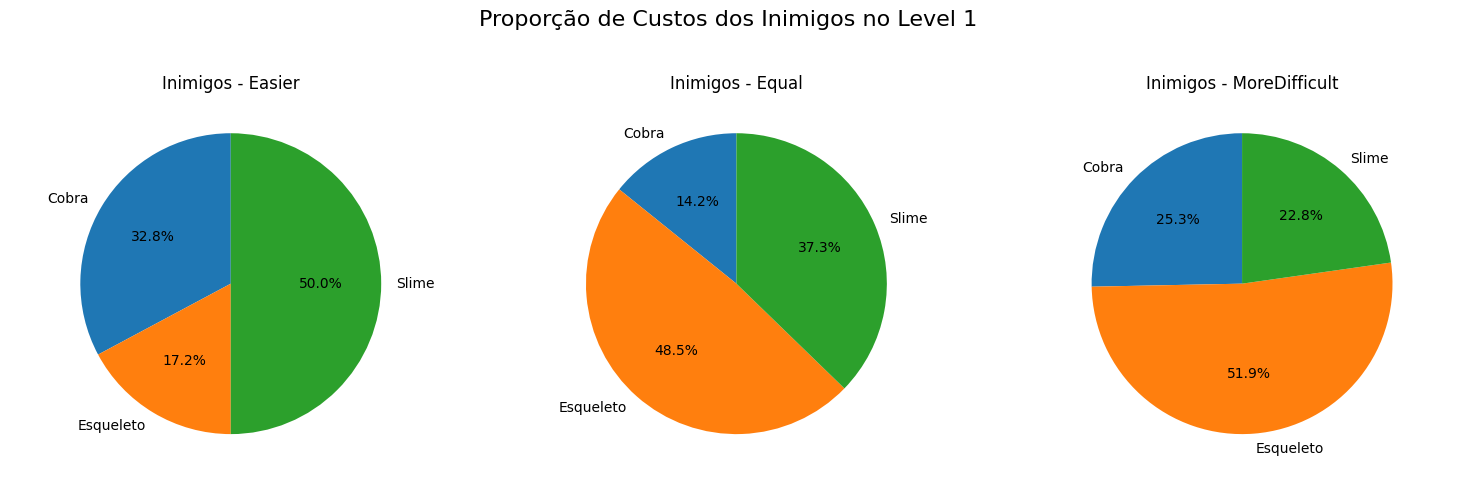

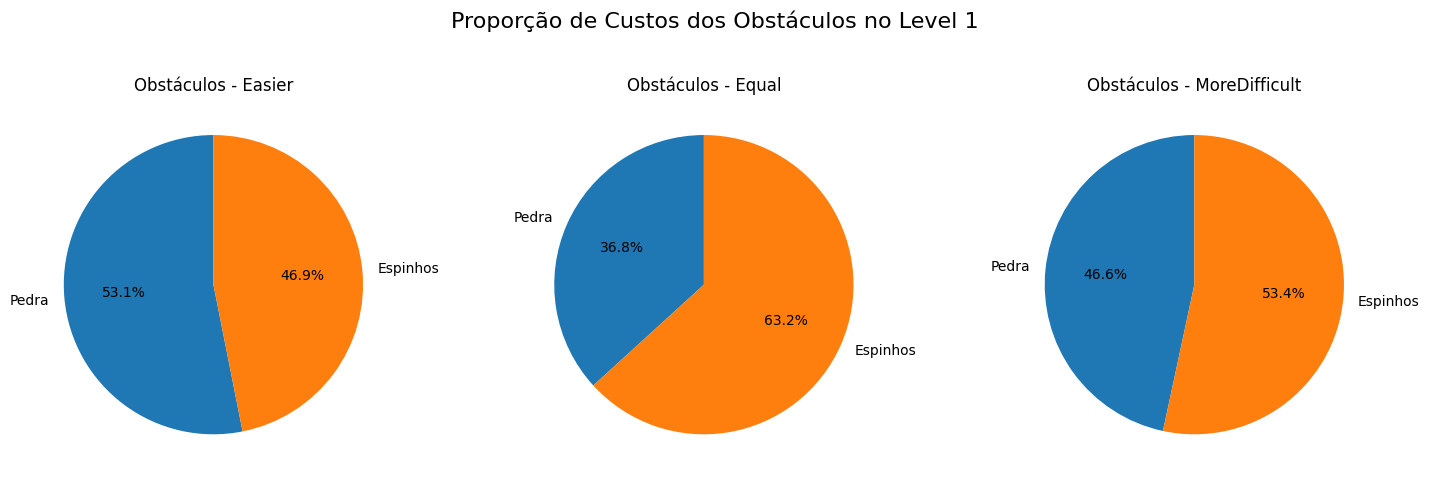

           Feedback  Feedback
Cobra     -0.044957 -0.044957
Esqueleto  0.336487  0.336487
Slime     -0.296827 -0.296827
Feedback   1.000000  1.000000
Pedra     -0.027194 -0.027194
Espinhos   0.027194  0.027194
Feedback   1.000000  1.000000


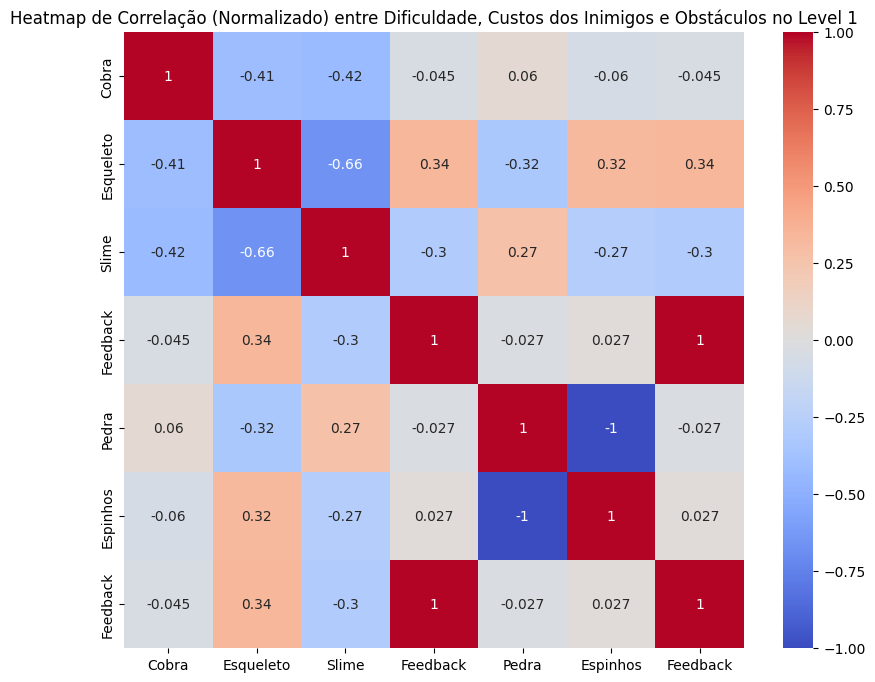

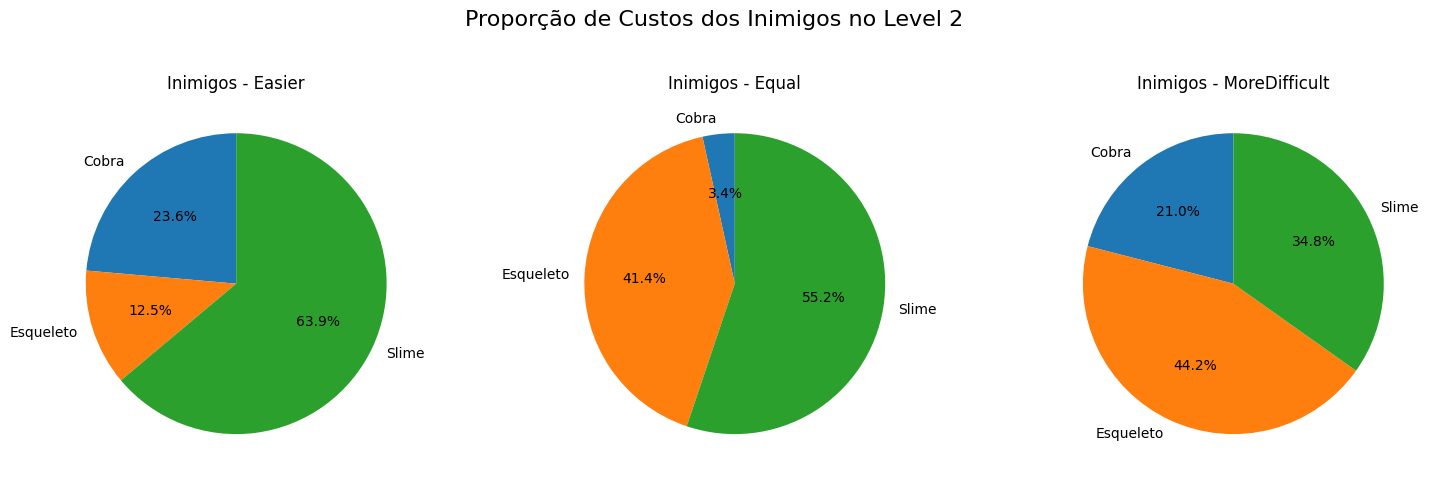

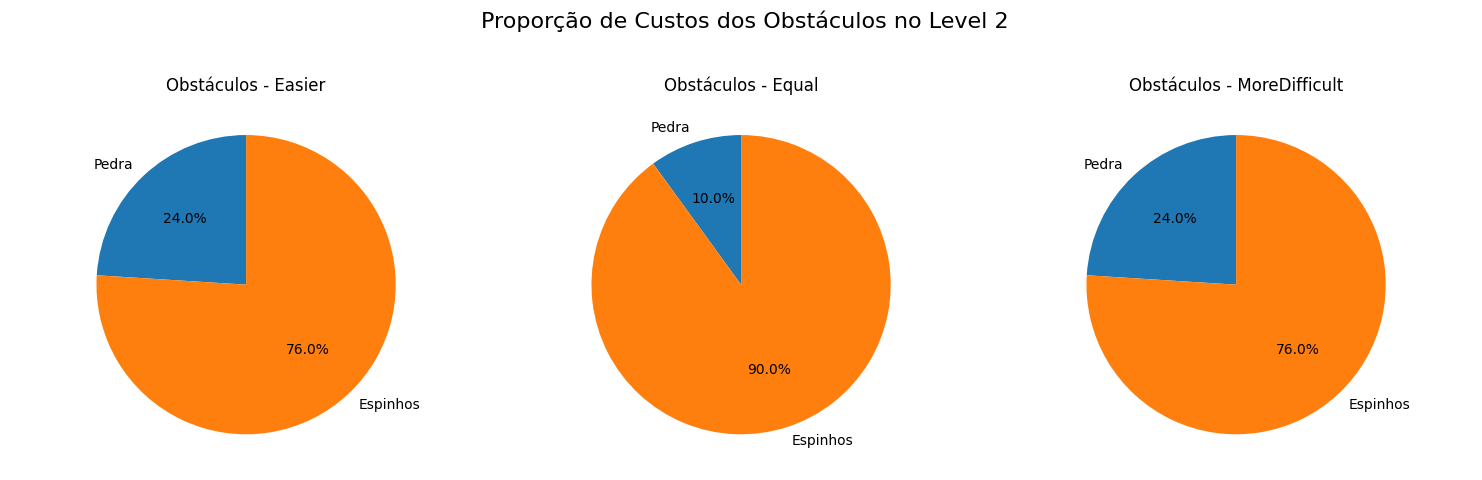

           Feedback  Feedback
Cobra      0.005718  0.005718
Esqueleto  0.356091  0.356091
Slime     -0.357367 -0.357367
Feedback   1.000000  1.000000
Pedra      0.030274  0.030274
Espinhos  -0.030274 -0.030274
Feedback   1.000000  1.000000


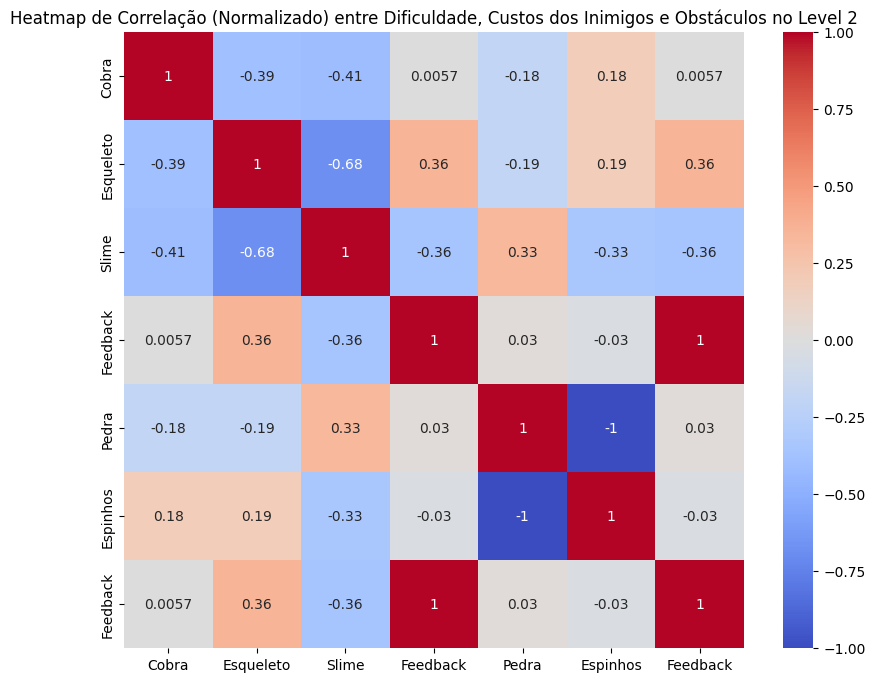

In [12]:
def plot_object_costs(df, level=None):
    df_costs = get_object_costs_by_feedback(df)

    print_pie_charts(df_costs, level)
    print_correlations_normalized(df_costs, level)

filtered_runs = runs[runs['player_feedback'] != '']
plot_for_each_level(filtered_runs, plot_object_costs)

#### Em um plot só

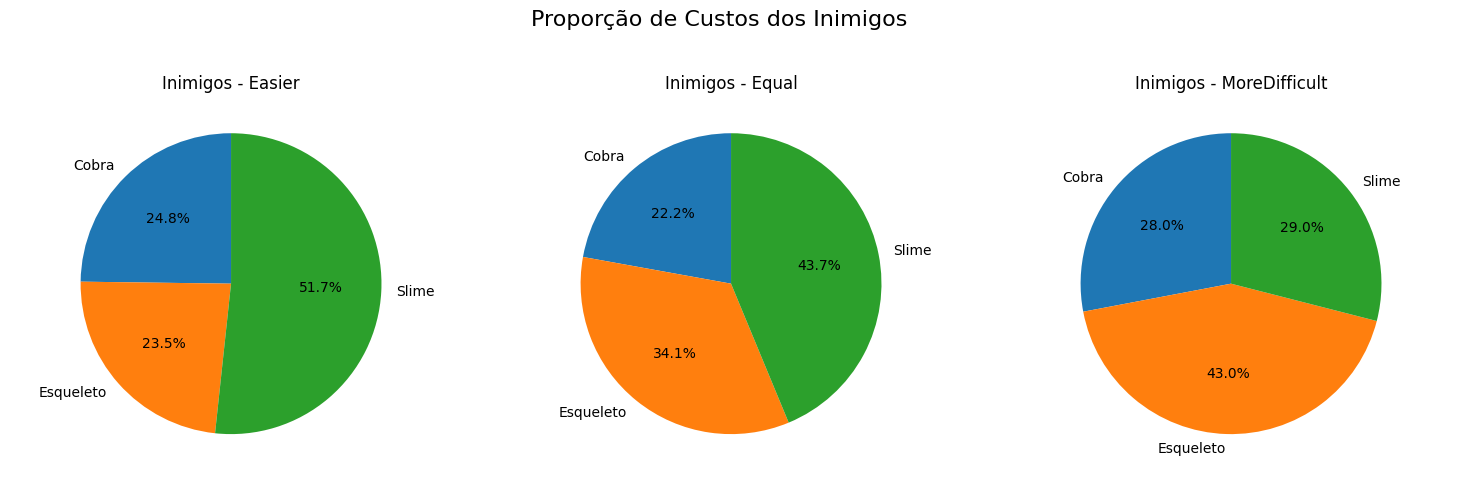

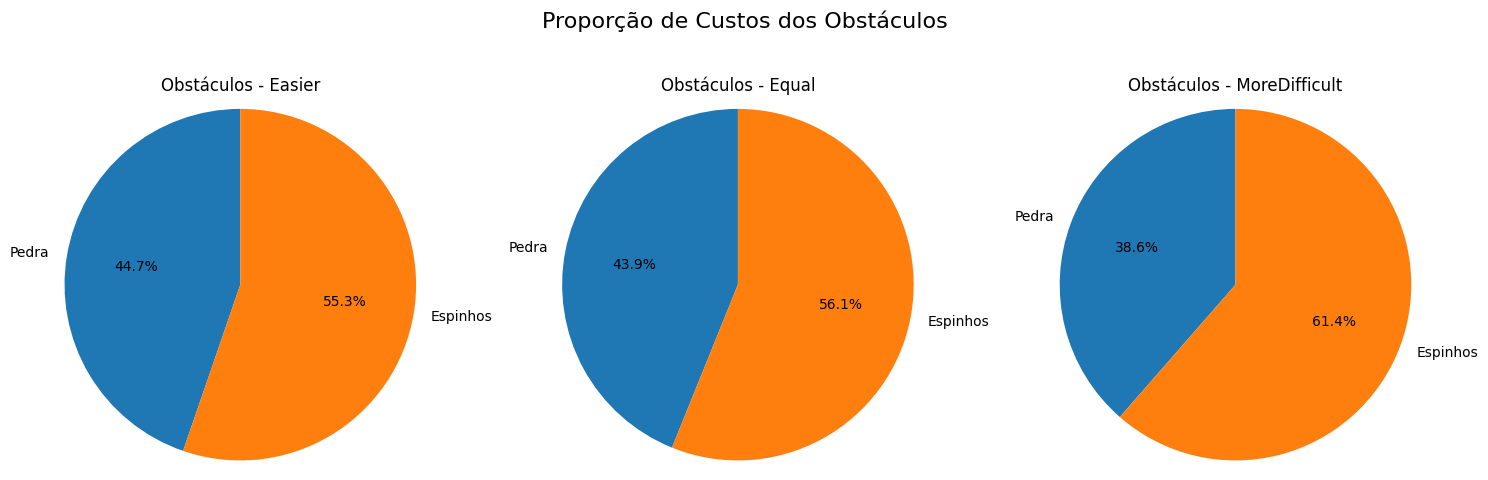

           Feedback  Feedback
Cobra      0.076659  0.076659
Esqueleto  0.177754  0.177754
Slime     -0.230824 -0.230824
Feedback   1.000000  1.000000
Pedra     -0.074745 -0.074745
Espinhos   0.074745  0.074745
Feedback   1.000000  1.000000


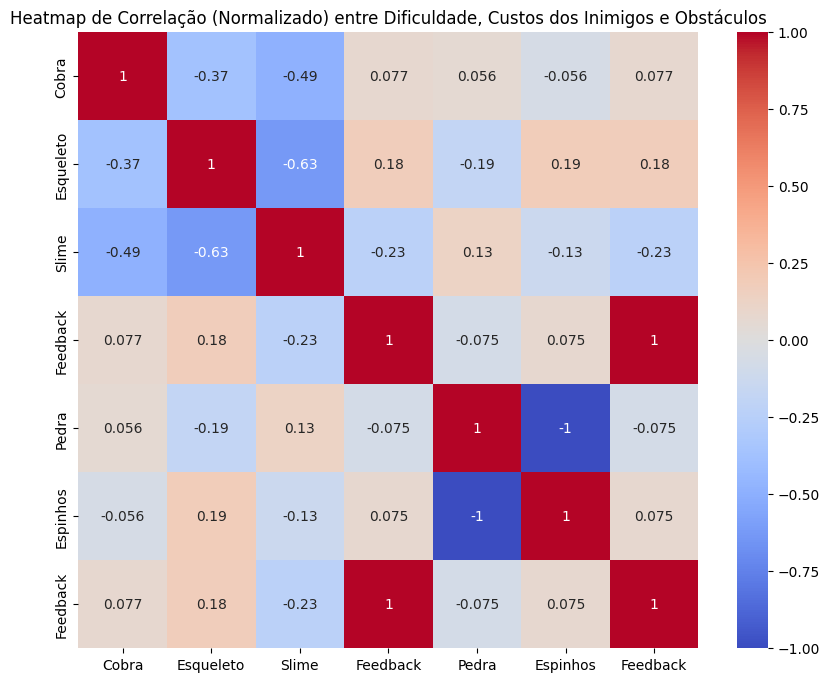

In [13]:
plot_object_costs(filtered_runs)

### Frequência de inimigos e obstáculos x feedback errado

#### Funções comuns

In [14]:
def get_object_costs_by_actual_difficulty(df):
    data = []

    for difficulty in df['actual_difficulty'].unique():
        df_difficulty_filtered = df[df['actual_difficulty'] == difficulty]

        for feedback in df_difficulty_filtered['player_feedback'].unique():
            df_feedback_filtered = df_difficulty_filtered[df_difficulty_filtered['player_feedback'] == feedback]

            for _, row in df_feedback_filtered.iterrows():
                costs = {name: 0 for name in enemy_names + obstacle_names}

                enemies = get_enemies_by_run_id(row['id'])
                obstacles = get_obstacles_by_run_id(row['id'])

                for _, row in enemies.iterrows():
                    name = row['nome']
                    quantity = row['quantity']

                    cost = enemy_weights[name] * quantity
                    costs[name] += cost

                for _, row in obstacles.iterrows():
                    name = row['nome']
                    quantity = row['quantity']

                    cost = obstacle_weights[name] * quantity
                    costs[name] += cost
                
                data.append({
                    'Actual_difficulty': difficulty,
                    'Feedback': feedback,
                    'Enemy1': costs.get('Enemy1', 0),
                    'Enemy2': costs.get('Enemy2', 0),
                    'Enemy3': costs.get('Enemy3', 0),
                    'Obstacle1': costs.get('Obstacle1', 0),
                    'Obstacle2': costs.get('Obstacle2', 0)
                })

    df_costs = pd.DataFrame(data)
    return df_costs

In [15]:
def print_pie_charts(df_costs, level=None):
    actual_difficulty_order = df_costs['Actual_difficulty'].unique()

    fig, axes = plt.subplots(len(actual_difficulty_order), len(feedback_order), figsize=(15, 10))

    for i, difficulty in enumerate(actual_difficulty_order):
        for j, feedback in enumerate(feedback_order):
            filtered_data = df_costs[(df_costs['Actual_difficulty'] == difficulty) & (df_costs['Feedback'] == feedback)]
            
            if not filtered_data.empty:
                enemy_columns = ['Enemy1', 'Enemy2', 'Enemy3']
                total_costs = filtered_data[enemy_columns].mean()

                transformed_labels = [enemy_name_map.get(label, label) for label in total_costs.index]

                axes[i, j].pie(total_costs, labels=transformed_labels, autopct='%1.1f%%', startangle=90)
                axes[i, j].set_title(f'Inimigos - {difficulty} / {feedback}')
                axes[i, j].axis('equal')
    
    if level is not None:
        plt.suptitle(f'Proporção de Custos dos Inimigos no Level {level}', fontsize=16)
        plt.savefig(f'{folder_path}/wrong_feedback_enemies_cost_distribution_level_{level}.png', dpi=96, bbox_inches='tight')
    else:
        plt.suptitle(f'Proporção de Custos dos Inimigos', fontsize=16)
        plt.savefig(f'{folder_path}/wrong_feedback_enemies_cost_distribution.png', dpi=96, bbox_inches='tight')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    fig, axes = plt.subplots(len(actual_difficulty_order), len(feedback_order), figsize=(15, 10))

    for i, difficulty in enumerate(actual_difficulty_order):
        for j, feedback in enumerate(feedback_order):
            filtered_data = df_costs[(df_costs['Actual_difficulty'] == difficulty) & (df_costs['Feedback'] == feedback)]
            
            if not filtered_data.empty:
                obstacle_columns = ['Obstacle1', 'Obstacle2']
                total_costs = filtered_data[obstacle_columns].mean()

                transformed_labels = [obstacle_name_map.get(label, label) for label in total_costs.index]

                axes[i, j].pie(total_costs, labels=transformed_labels, autopct='%1.1f%%', startangle=90)
                axes[i, j].set_title(f'Obstáculos - {difficulty} / {feedback}')
                axes[i, j].axis('equal')

    if level is not None:
        plt.suptitle(f'Proporção de Custos dos Obstáculos no Level {level}', fontsize=16)
        plt.savefig(f'{folder_path}/wrong_actual_difficulty_obstacles_cost_distribution_level_{level}.png', dpi=96, bbox_inches='tight')
    else:
        plt.suptitle('Proporção de Custos dos Obstáculos', fontsize=16)
        plt.savefig(f'{folder_path}/wrong_actual_difficulty_obstacles_cost_distribution.png', dpi=96, bbox_inches='tight')
        
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [16]:
def normalize_by_row(df):
    return df.div(df.sum(axis=1), axis=0)

def print_correlations_normalized(df_costs, level=None):
    df_enemies = df_costs[['Enemy1', 'Enemy2', 'Enemy3']]
    df_obstacles = df_costs[['Obstacle1', 'Obstacle2']]
    
    df_enemies_normalized = normalize_by_row(df_enemies)
    df_obstacles_normalized = normalize_by_row(df_obstacles)
    
    df_enemies_normalized['Feedback'] = df_costs['Feedback'].map(feedback_mapping)
    df_enemies_normalized['ActualDifficulty'] = df_costs['Actual_difficulty'].map(feedback_mapping)

    df_obstacles_normalized['Feedback'] = df_costs['Feedback'].map(feedback_mapping)
    df_obstacles_normalized['ActualDifficulty'] = df_costs['Actual_difficulty'].map(feedback_mapping)

    enemy_correlation_matrix = df_enemies_normalized.corr()

    print(enemy_correlation_matrix['Feedback'])
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(enemy_correlation_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)

    if level is not None:
        plt.title(f"Heatmap de Correlação (Normalizado) entre Dificuldade e Custos dos Inimigos no Level {level}")
        plt.savefig(f'{folder_path}/correlation_enemies_cost_feedback_level_{level}.png', dpi=96, bbox_inches='tight')
    else:
        plt.title("Heatmap de Correlação (Normalizado) entre Dificuldade e Custos dos Inimigos")
        plt.savefig(f'{folder_path}/correlation_enemies_cost_feedback.png', dpi=96, bbox_inches='tight')

    plt.show()
    
    obstacle_correlation_matrix = df_obstacles_normalized.corr()
    print(obstacle_correlation_matrix['Feedback'])
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(obstacle_correlation_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)

    if level is not None:
        plt.title(f"Heatmap de Correlação (Normalizado) entre Dificuldade e Custos dos Obstáculos no Level {level}")
        plt.savefig(f'{folder_path}/correlation_obstacles_cost_feedback_level_{level}.png', dpi=96, bbox_inches='tight')
    else:
        plt.title("Heatmap de Correlação (Normalizado) entre Dificuldade e Custos dos Obstáculos")
        plt.savefig(f'{folder_path}/correlation_obstacles_cost_feedback.png', dpi=96, bbox_inches='tight')

    plt.show()

#### Um plot para cada nível

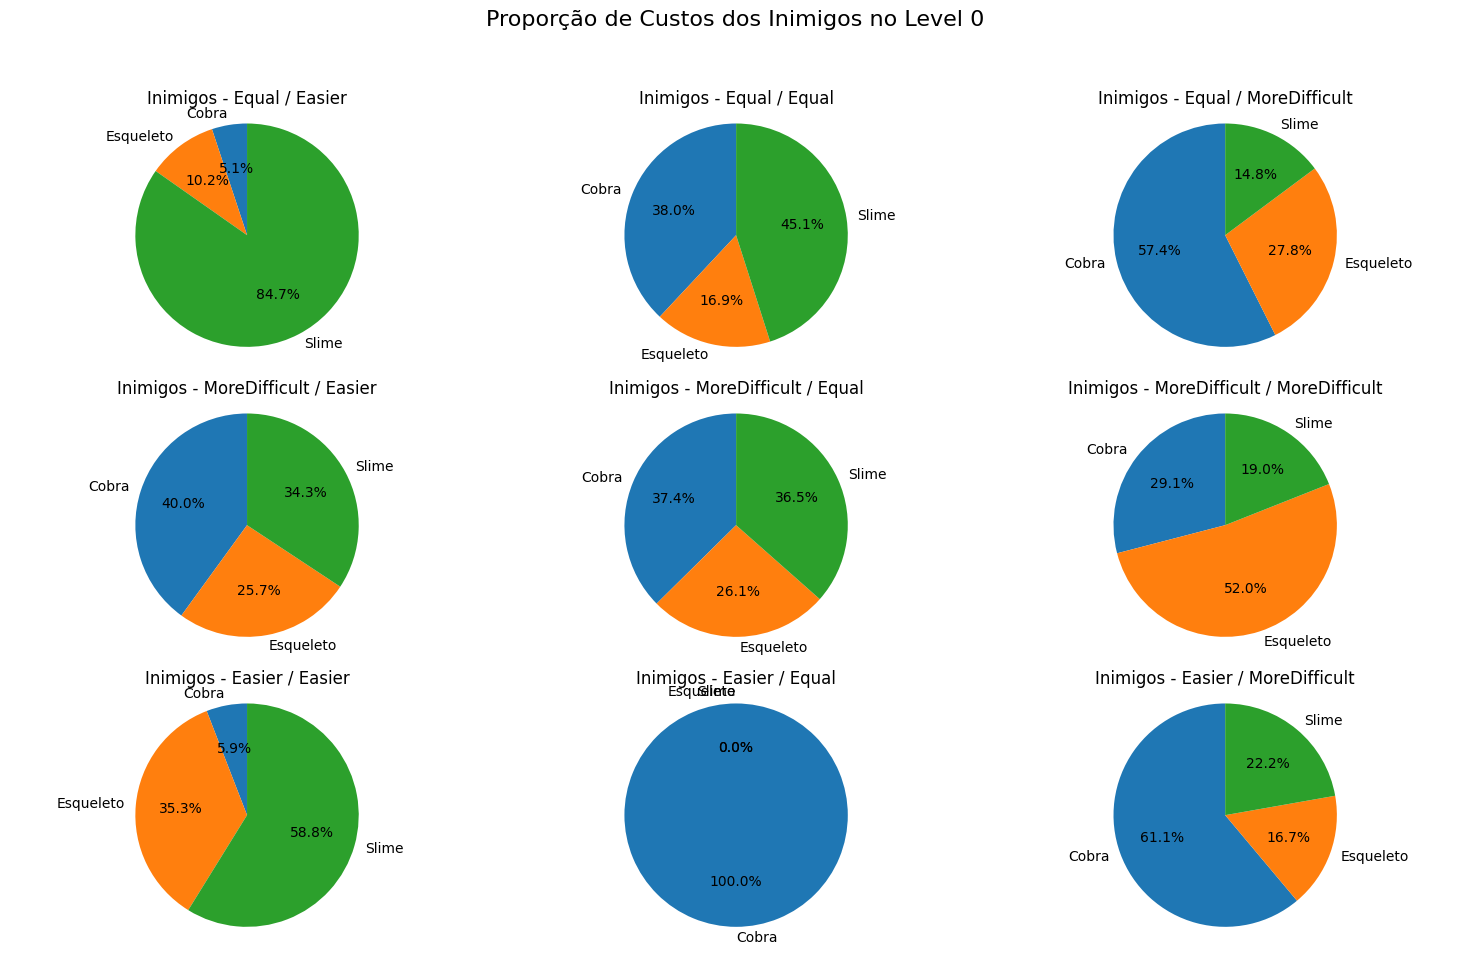

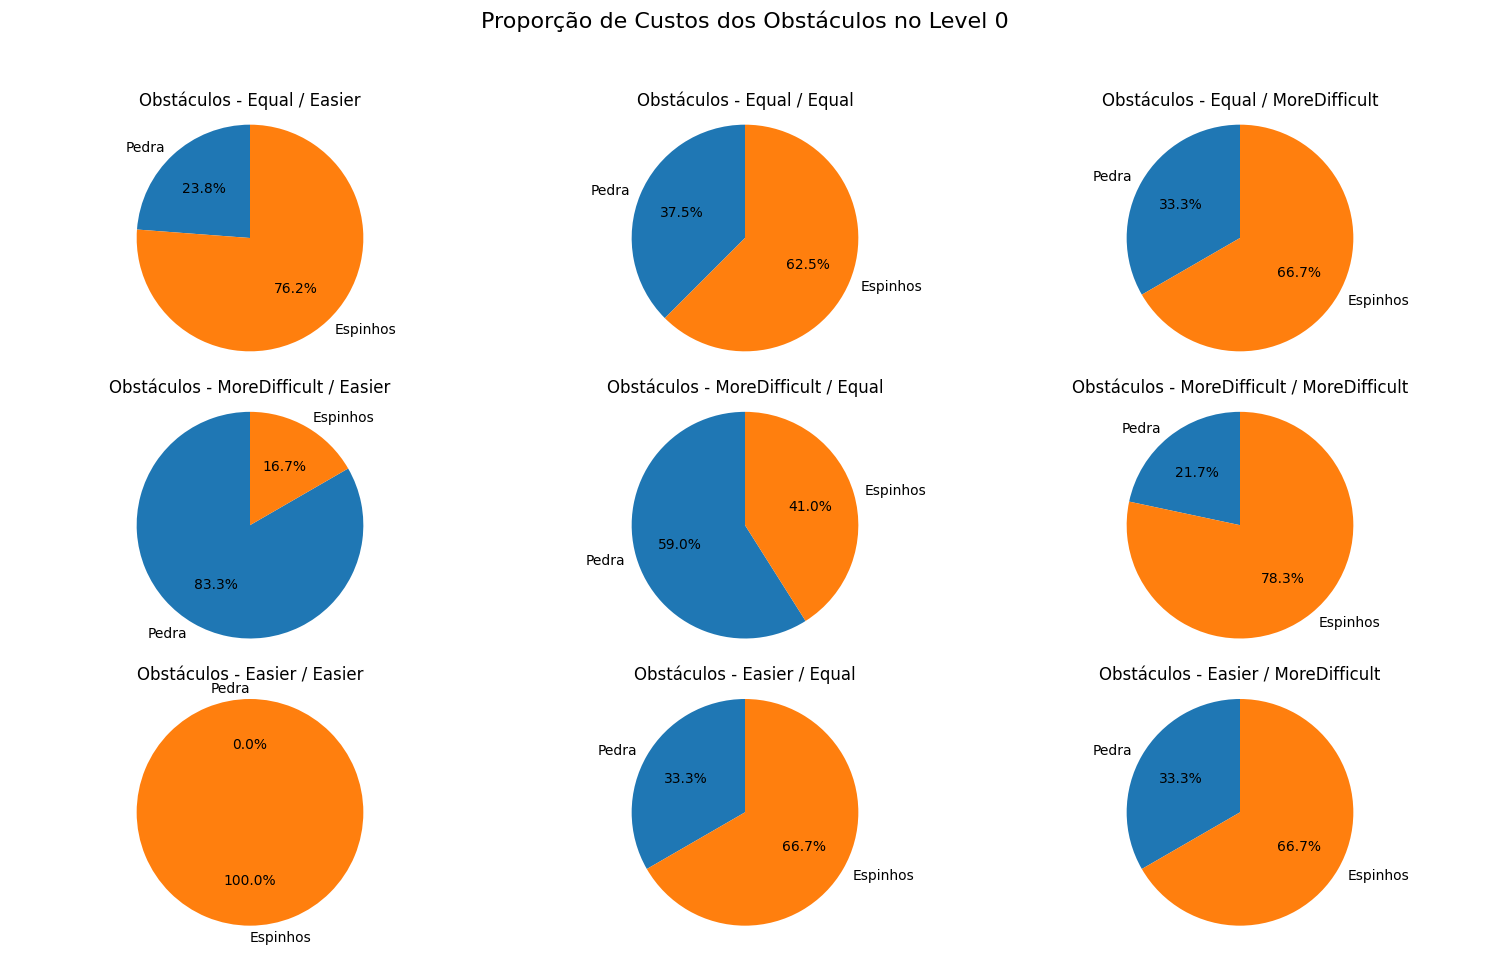

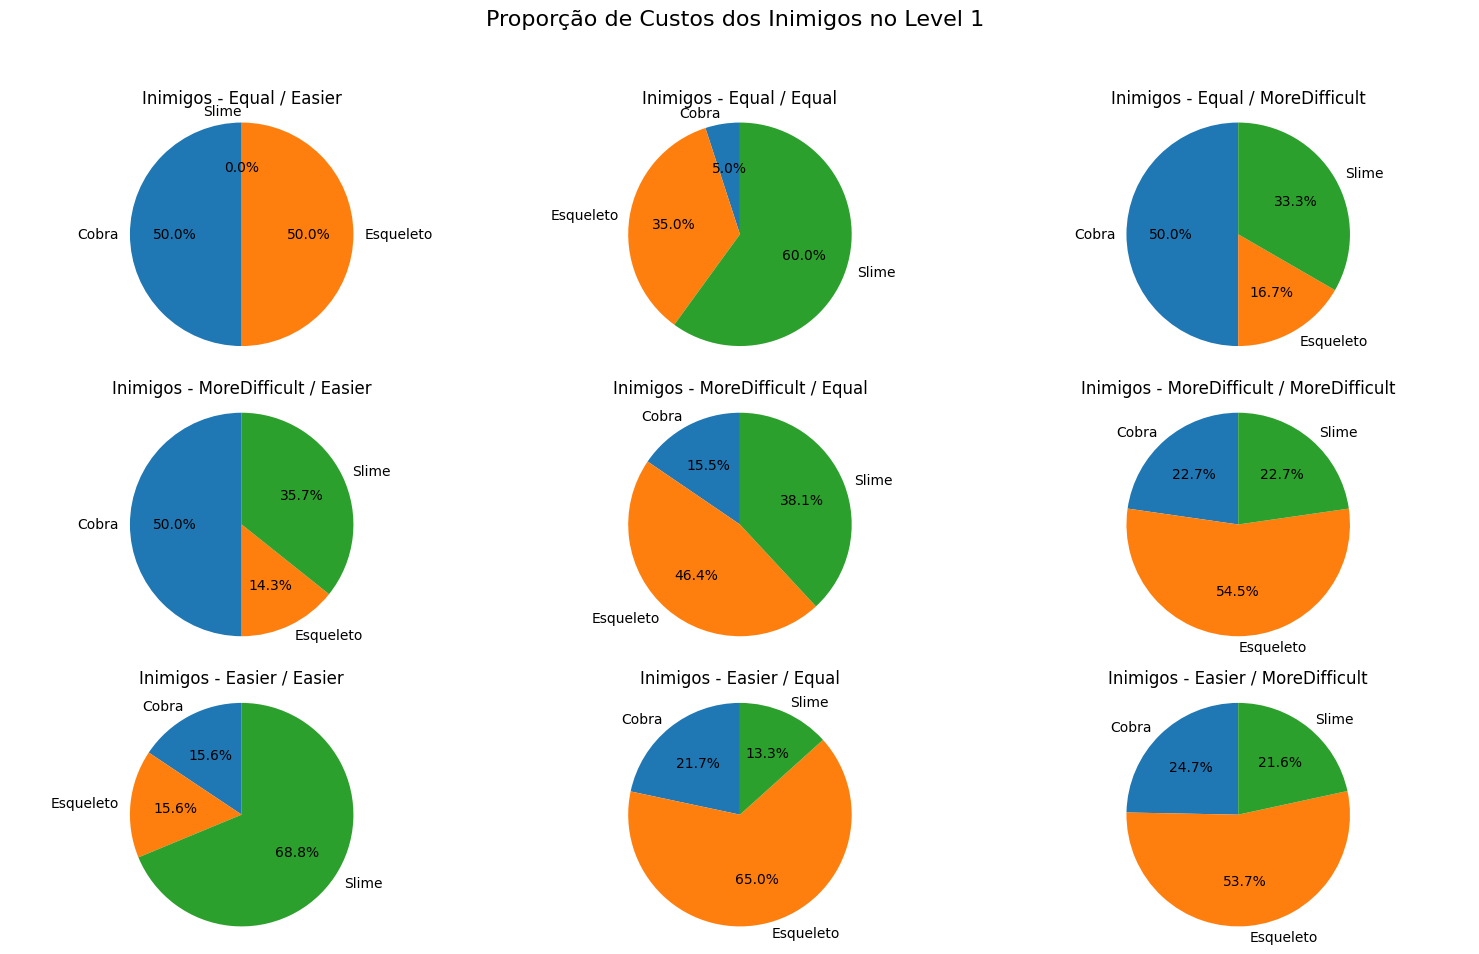

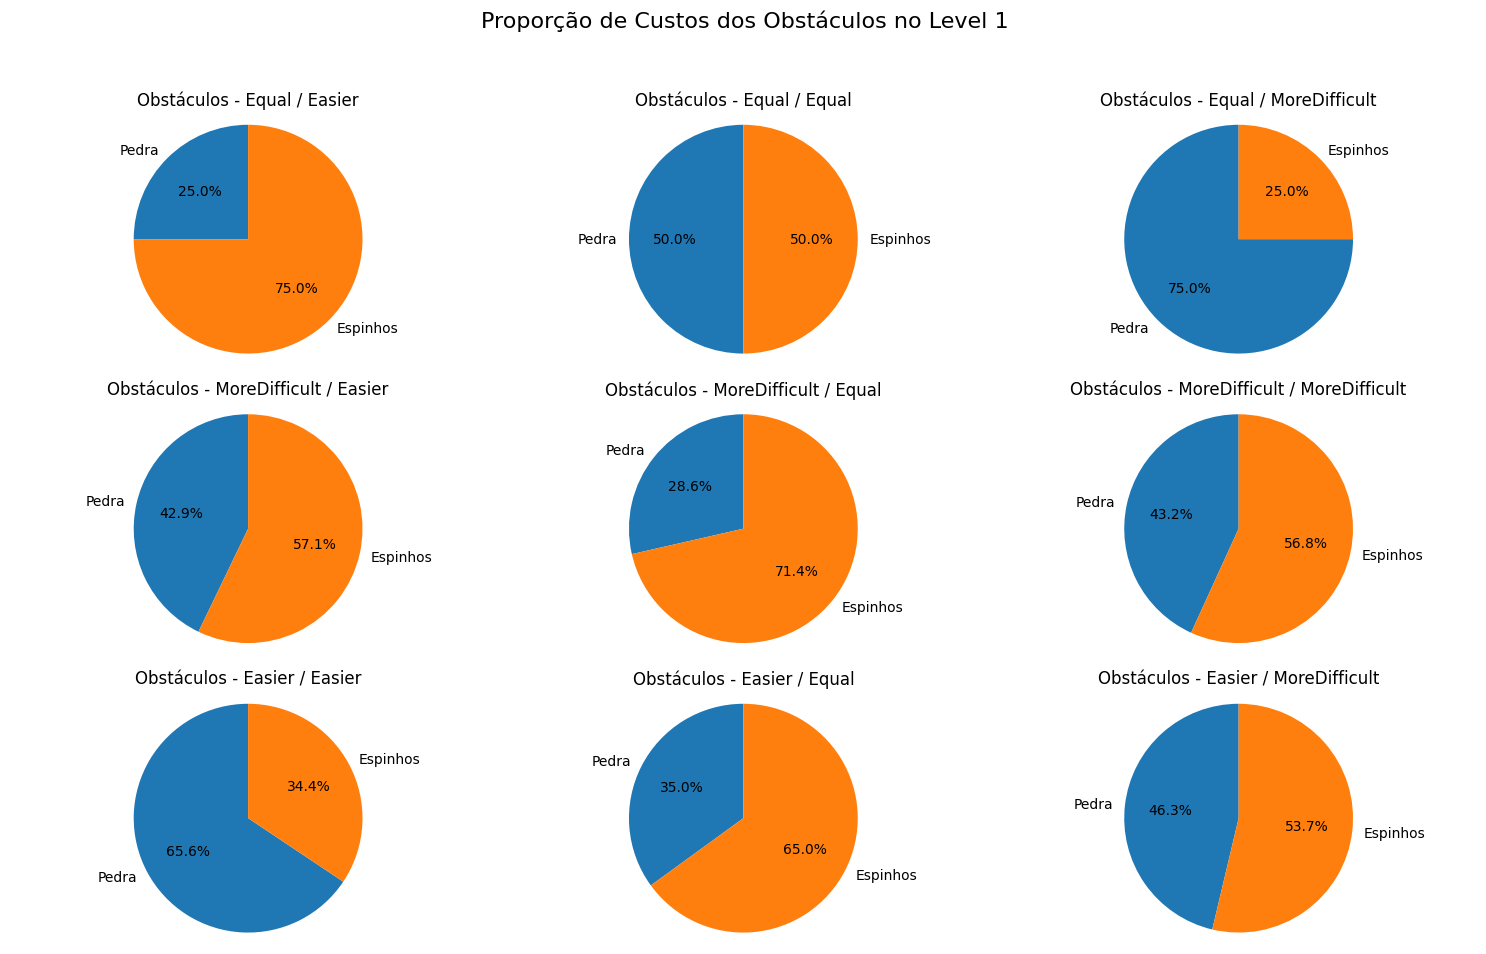

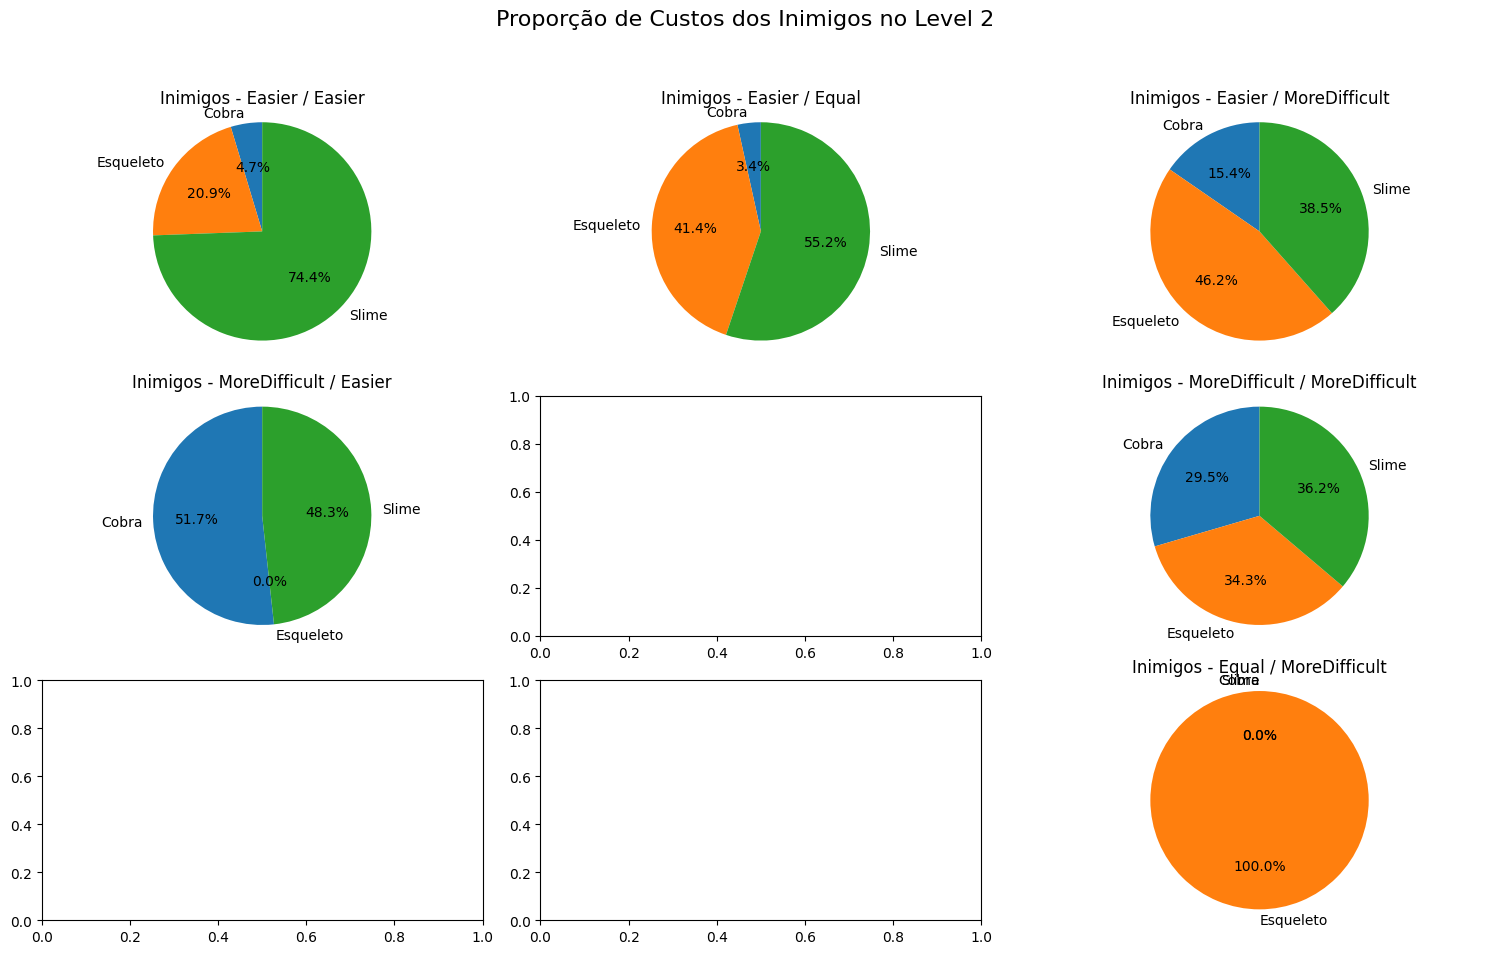

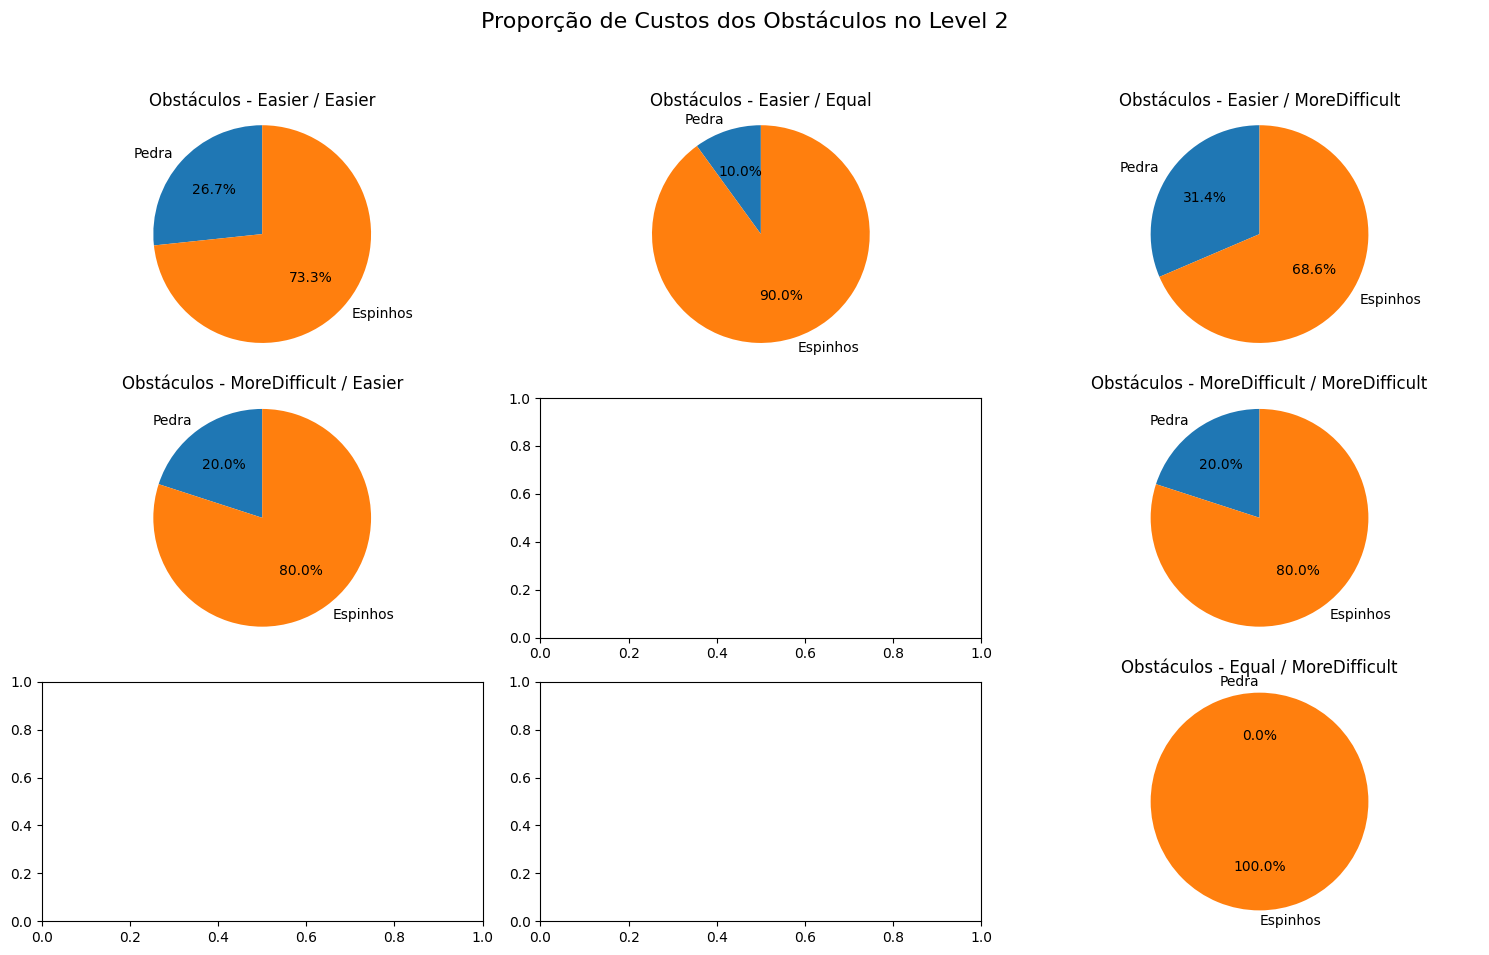

In [17]:
def plot_object_costs(df, level=None):
    df_costs = get_object_costs_by_actual_difficulty(df)
    print_pie_charts(df_costs, level)
    #print_correlations_normalized(df_costs, level)

filtered_runs = runs[runs['player_feedback'] != '']
plot_for_each_level(filtered_runs, plot_object_costs)

#### Em um plot só

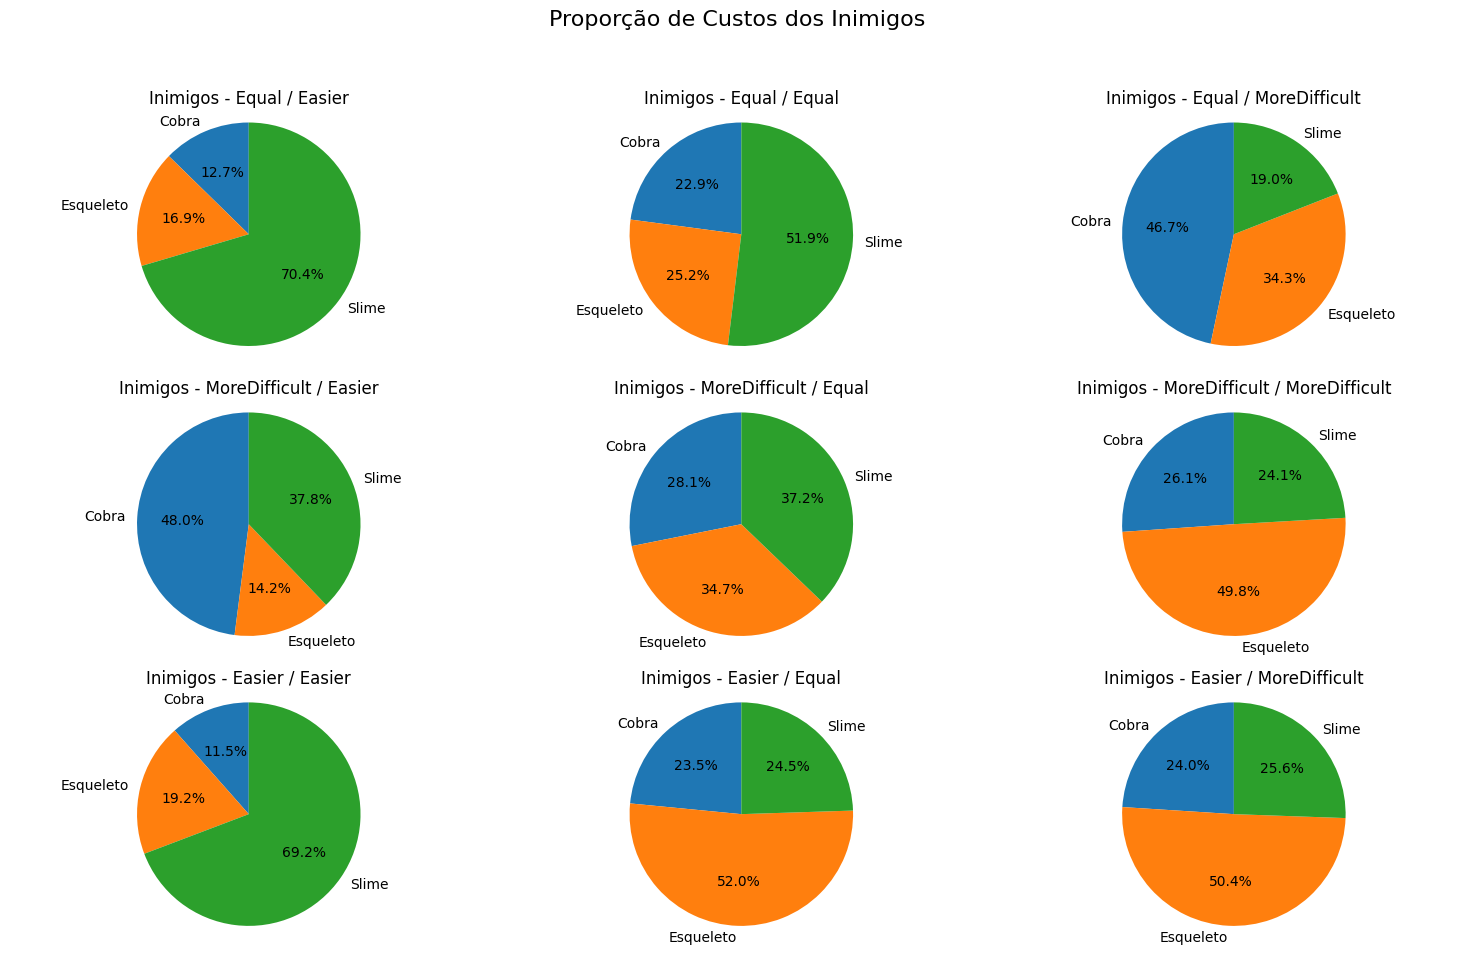

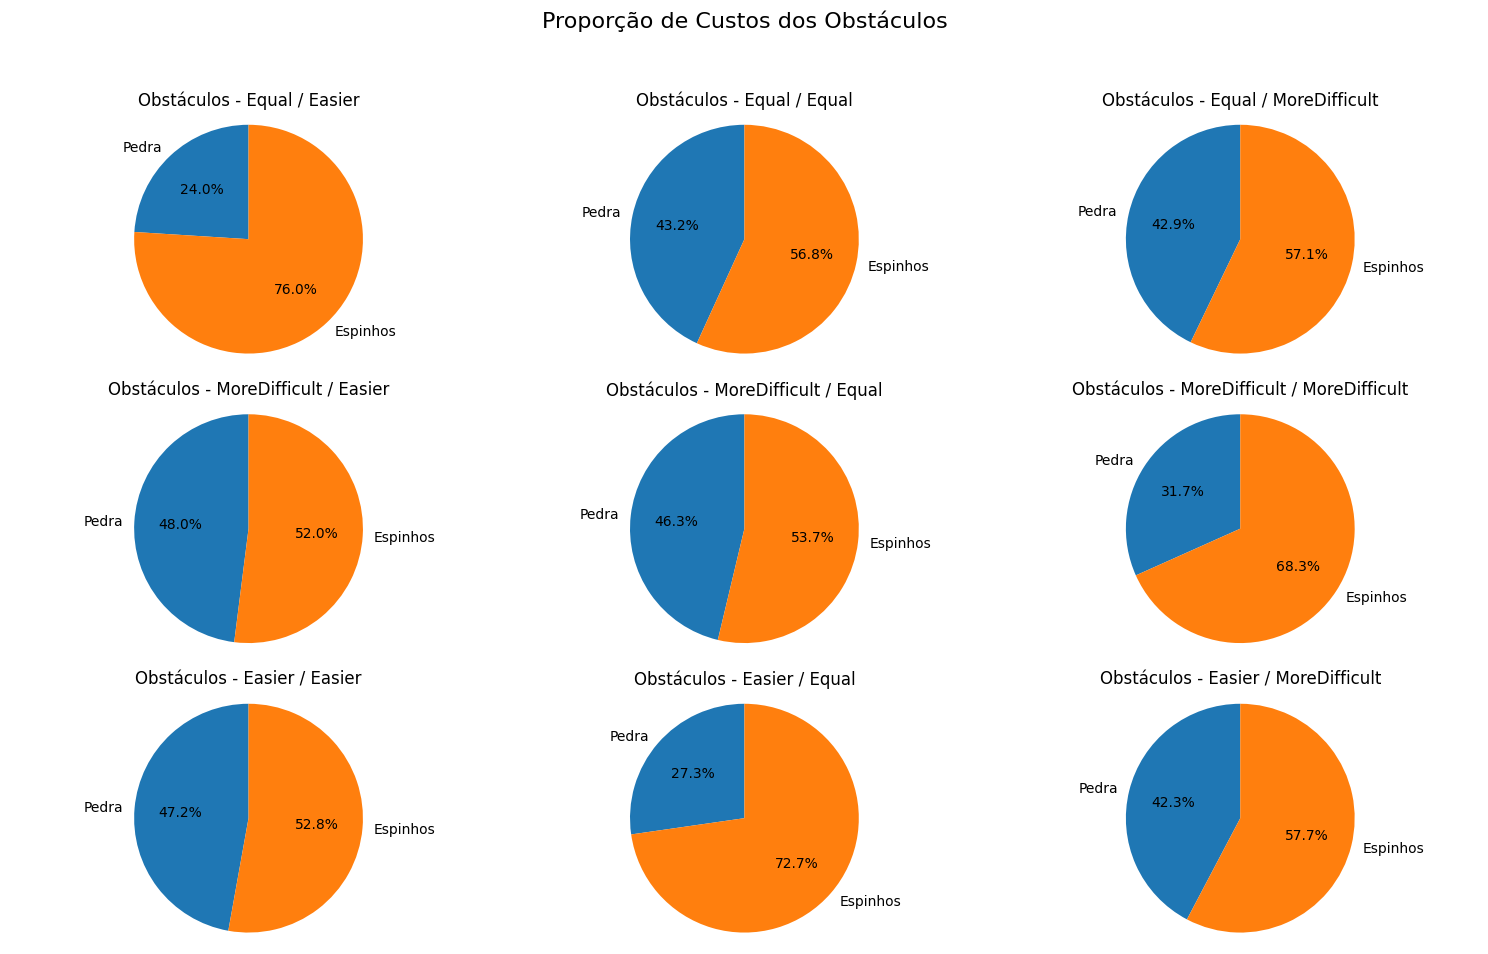

In [18]:
plot_object_costs(filtered_runs)

### Frequência de inimigos e obstáculos x conclusão da sala

#### Funções comuns

In [19]:
def melt_data_by_completed(df, cols, new_col_name):
    return pd.melt(df, id_vars=['Completed'], value_vars=cols, var_name=new_col_name, value_name='Values')

result_data = []

for level in range(0, 3):
    df_filtered = runs[runs['level'] == level]
    for completed in df_filtered['is_completed'].unique():
        df_filtered_completed = df_filtered[df_filtered['is_completed'] == completed]
        for level in df_filtered_completed['level'].unique():
            total_cost = level_cost[level]
            df_completed_level = df_filtered_completed[df_filtered_completed['level'] == level]

            for _, row in df_completed_level.iterrows():
                enemies = get_enemies_by_run_id(row['id'])
                obstacles = get_obstacles_by_run_id(row['id'])

                costs = {}
                for _, row in enemies.iterrows():
                    name = row['nome']
                    quantity = row['quantity']

                    cost = enemy_weights[name] * quantity
                    costs[name] = cost

                for _, row in obstacles.iterrows():
                    name = row['nome']
                    quantity = row['quantity']

                    cost = obstacle_weights[name] * quantity
                    costs[name] = cost

                result_data.append({
                    'level': level,
                    'Completed': completed,
                    'Enemy1': costs.get('Enemy1', 0),
                    'Enemy2': costs.get('Enemy2', 0),
                    'Enemy3': costs.get('Enemy3', 0),
                    'Obstacle1': costs.get('Obstacle1', 0),
                    'Obstacle2': costs.get('Obstacle2', 0)
                })

df_costs = pd.DataFrame(result_data)

In [20]:
def print_pie_charts(df, level=None):
    grouped_costs = df.groupby('Completed').mean()

	# Enemies
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    for i, completed_status in enumerate(grouped_costs.index):
        enemy_costs = grouped_costs.loc[completed_status, ['Enemy1', 'Enemy2', 'Enemy3']]

        transformed_labels = [enemy_name_map.get(label, label) for label in enemy_costs.index]
        
        axes[i].pie(enemy_costs, labels=transformed_labels, autopct='%1.1f%%', startangle=90)
        axes[i].set_title(f"Inimigos - {'Completado' if completed_status else 'Não Completado'}")

    if level is not None:
        plt.suptitle(f"Distribuição de Custos dos Inimigos por Status de Completude no Level {level}", fontsize=16)
        plt.savefig(f'{folder_path}/enemies_cost_completed_level_{level}.png', dpi=96, bbox_inches='tight')
    else:
        plt.suptitle("Distribuição de Custos dos Inimigos por Status de Completude", fontsize=16)
        plt.savefig(f'{folder_path}/enemies_cost_completed.png', dpi=96, bbox_inches='tight')

    plt.tight_layout()
    plt.show()

	# Obstacles
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    for i, completed_status in enumerate(grouped_costs.index):
        obstacle_costs = grouped_costs.loc[completed_status, ['Obstacle1', 'Obstacle2']]

        transformed_labels = [obstacle_name_map.get(label, label) for label in obstacle_costs.index]

        axes[i].pie(obstacle_costs, labels=transformed_labels, autopct='%1.1f%%', startangle=90)
        axes[i].set_title(f"Obstáculos - {'Completado' if completed_status else 'Não Completado'}")

    if level is not None:
        plt.suptitle(f"Distribuição de Custos dos Obstáculos por Status de Completude no Level {level}", fontsize=16)
        plt.savefig(f'{folder_path}/obstacles_cost_completed_level_{level}.png', dpi=96, bbox_inches='tight')
    else:
        plt.suptitle("Distribuição de Custos dos Obstáculos por Status de Completude", fontsize=16)
        plt.savefig(f'{folder_path}/obstacles_cost_completed.png', dpi=96, bbox_inches='tight')

    plt.tight_layout()
    plt.show()

In [21]:
def normalize_by_row(df, columns_to_normalize):
    row_sums = df[columns_to_normalize].sum(axis=1)
    df_normalized = df[columns_to_normalize].div(row_sums, axis=0)
    return df_normalized

def print_correlations_normalized(df, level=None):
    df_enemies_normalized = normalize_by_row(df, enemy_names)
    df_obstacles_normalized = normalize_by_row(df, obstacle_names)

    df_normalized = pd.concat([df['Completed'], df_enemies_normalized, df_obstacles_normalized], axis=1)
    
    correlation_matrix = df_normalized.corr()
    correlation_matrix.rename(index=name_mapping, columns=name_mapping, inplace=True)
    print(correlation_matrix['Completed'])

    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
    
    if level is not None:
        plt.title(f"Heatmap de Correlação entre 'Completed' e Outras Colunas no Level {level}", fontsize=16)
        plt.savefig(f'{folder_path}/correlation_cost_completed_level_{level}.png', dpi=96, bbox_inches='tight')
    else:
        plt.title("Heatmap de Correlação entre 'Completed' e Outras Colunas", fontsize=16)
        plt.savefig(f'{folder_path}/correlation_cost_completed.png', dpi=96, bbox_inches='tight')
    
    plt.show()

#### Um plot para cada nível

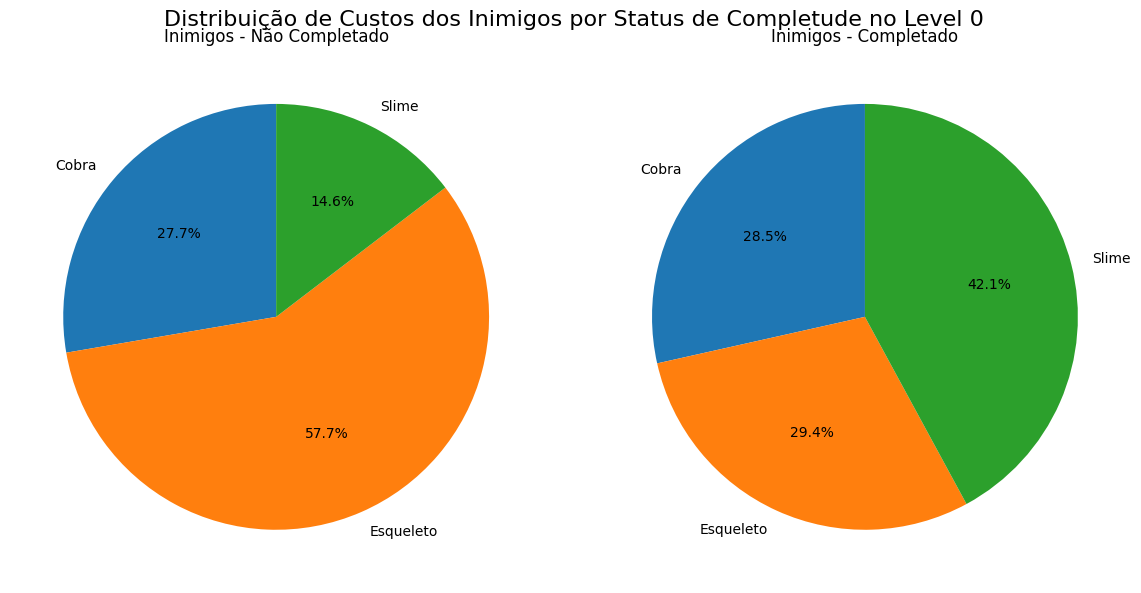

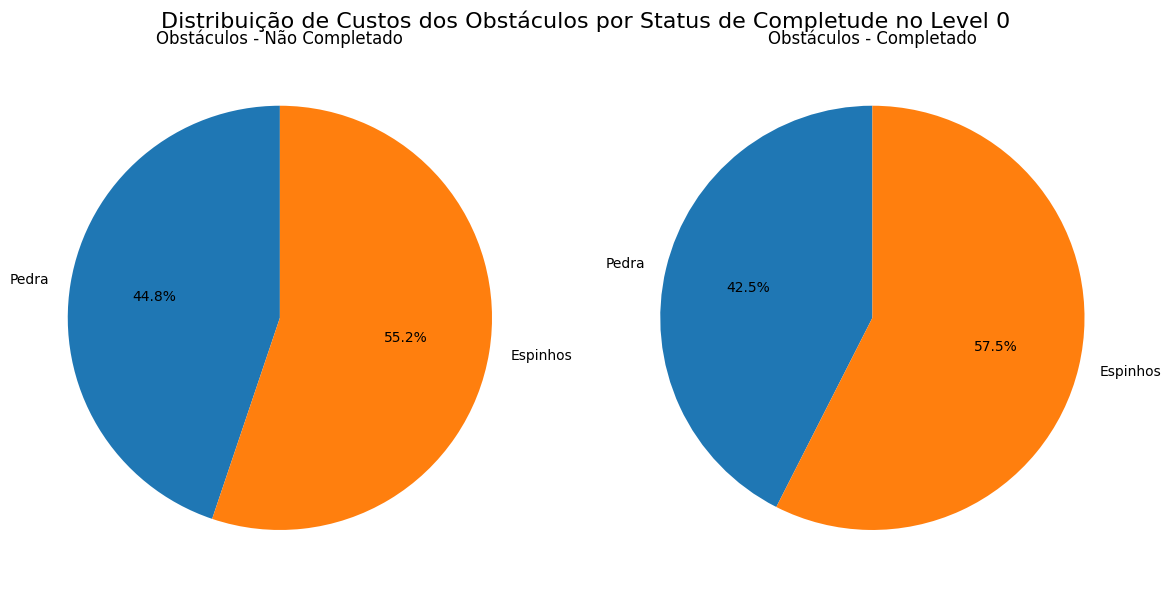

Completed    1.000000
Cobra        0.001604
Esqueleto   -0.289674
Slime        0.277702
Pedra       -0.023104
Espinhos     0.023104
Name: Completed, dtype: float64


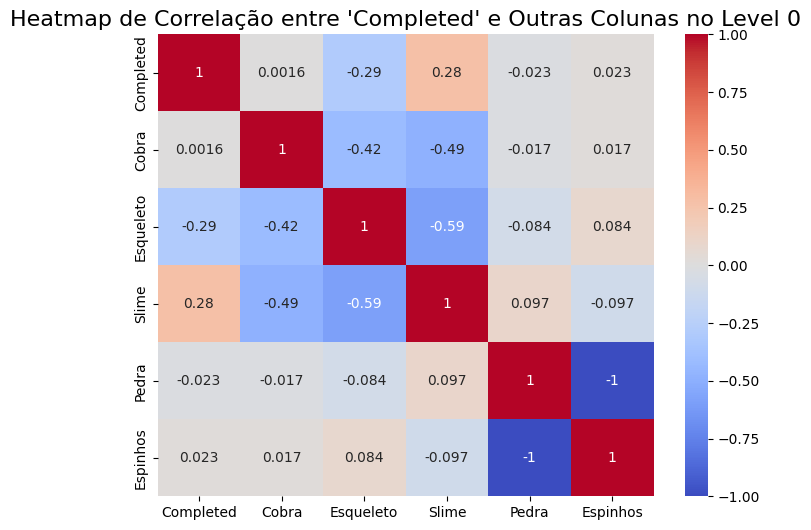

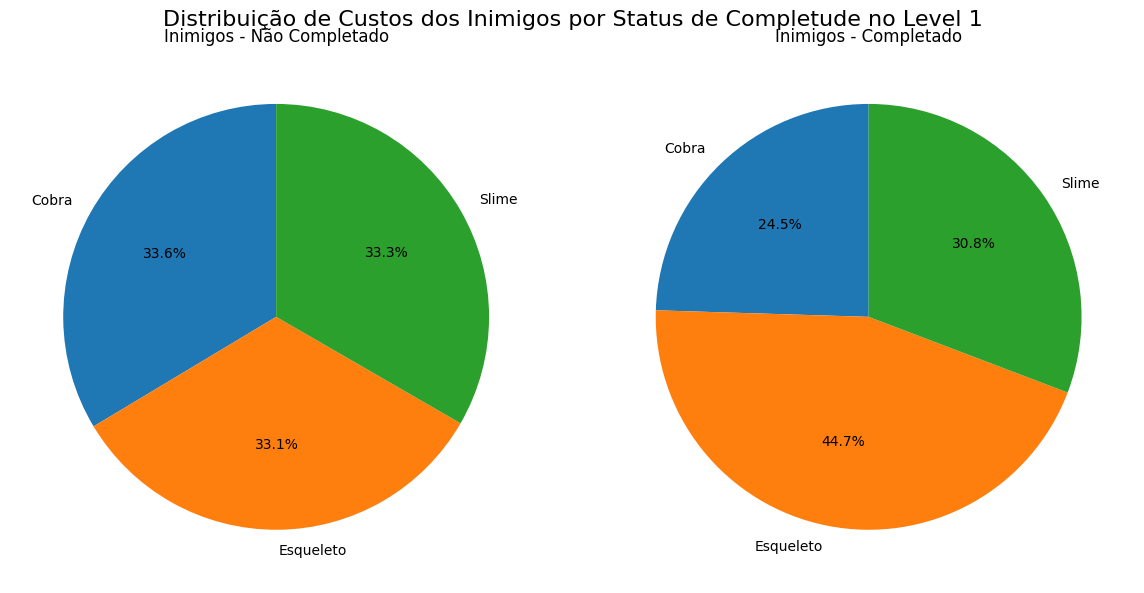

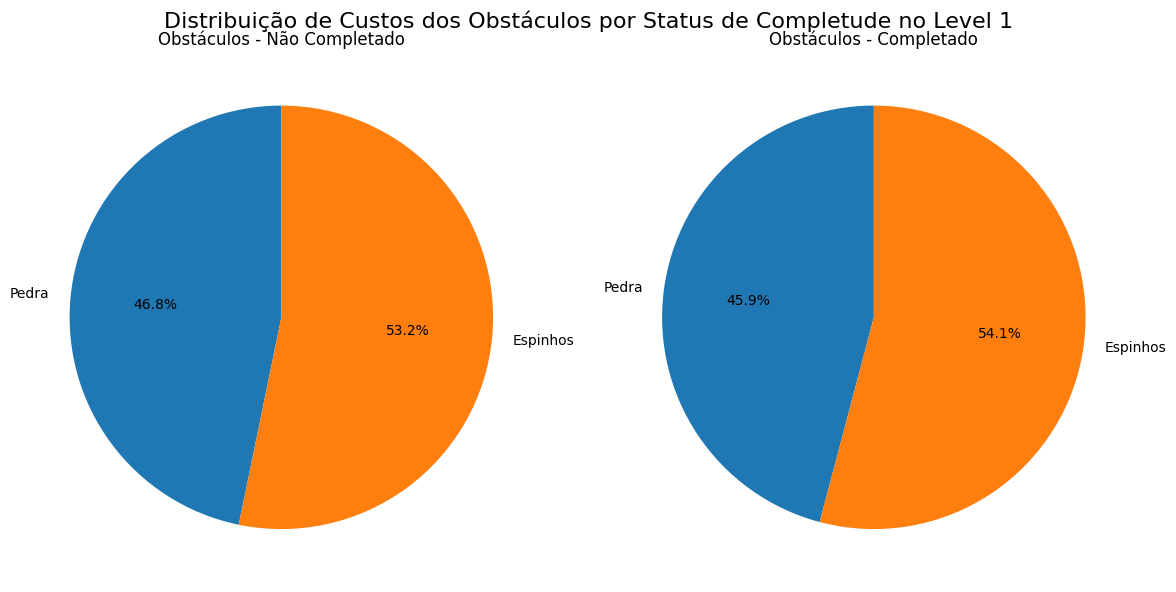

Completed    1.000000
Cobra       -0.126245
Esqueleto    0.144502
Slime       -0.031736
Pedra       -0.009797
Espinhos     0.009797
Name: Completed, dtype: float64


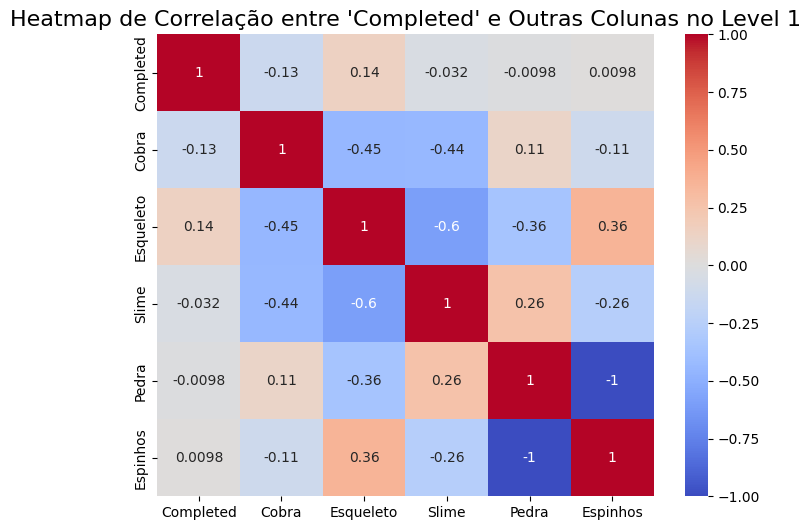

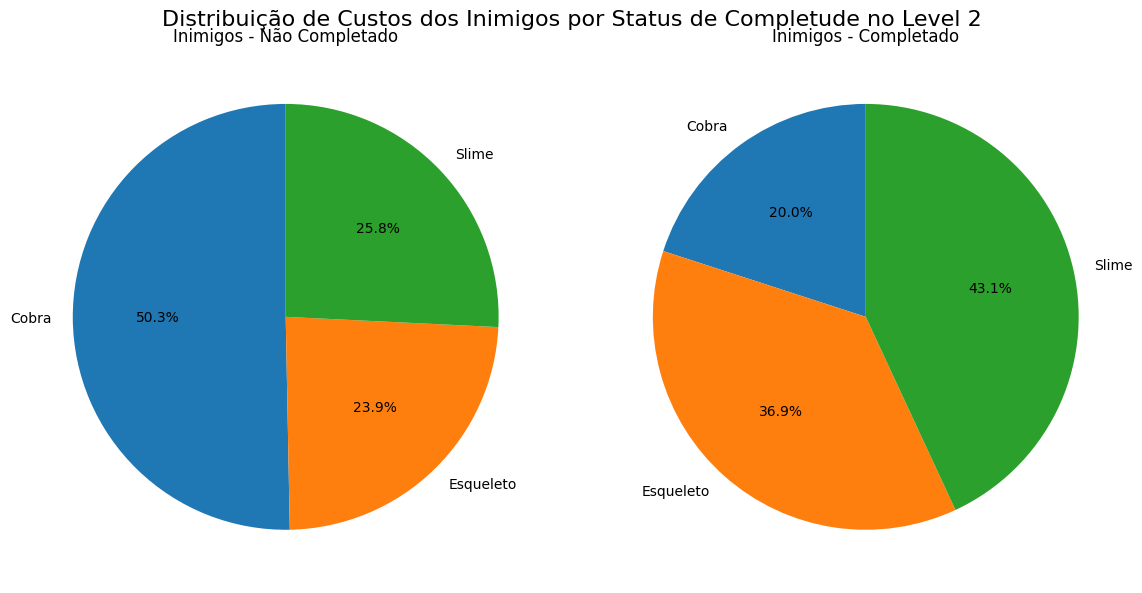

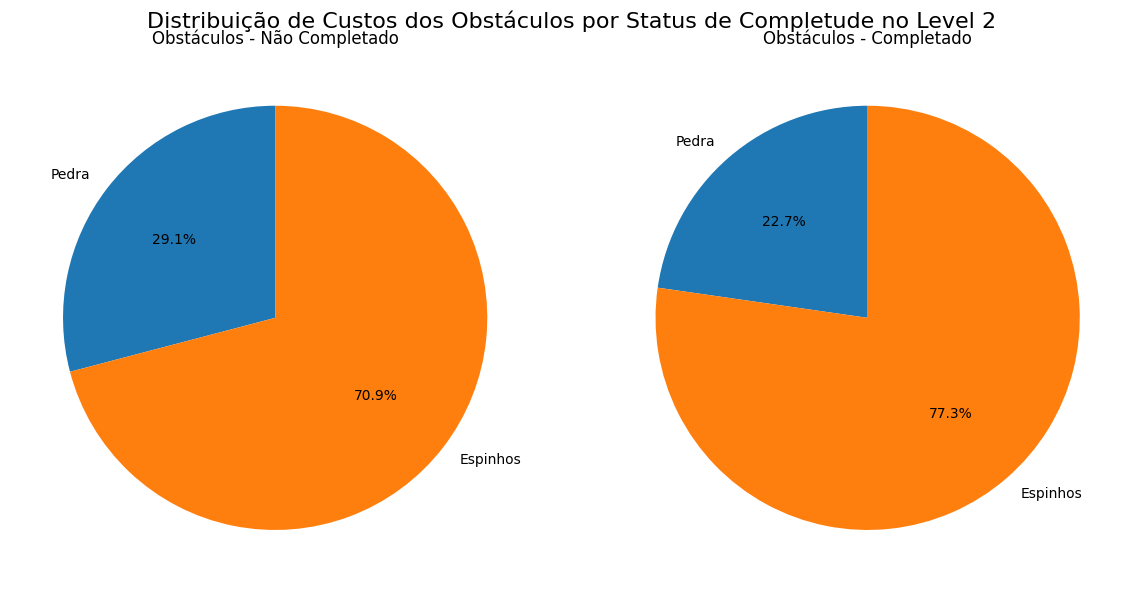

Completed    1.000000
Cobra       -0.369413
Esqueleto    0.170732
Slime        0.217090
Pedra       -0.107654
Espinhos     0.107654
Name: Completed, dtype: float64


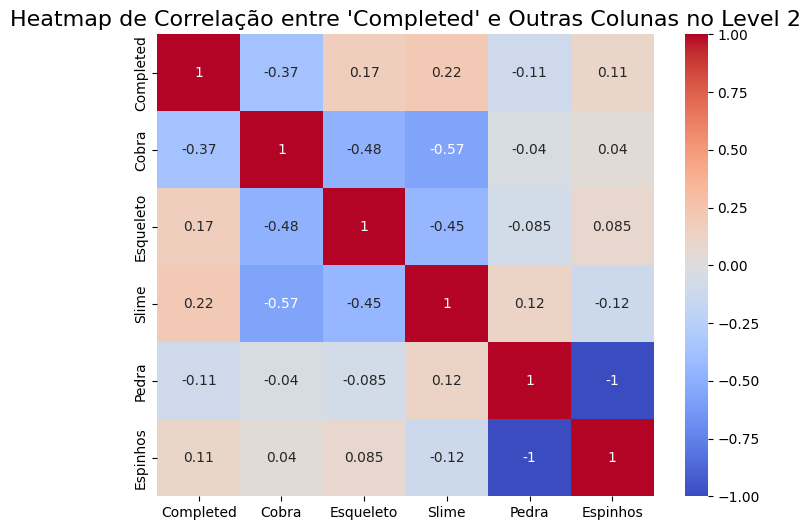

In [22]:
def plot_object_costs(df, level=None):
    print_pie_charts(df, level)
    print_correlations_normalized(df, level)

plot_for_each_level(df_costs, plot_object_costs)

#### Tudo em um plot só

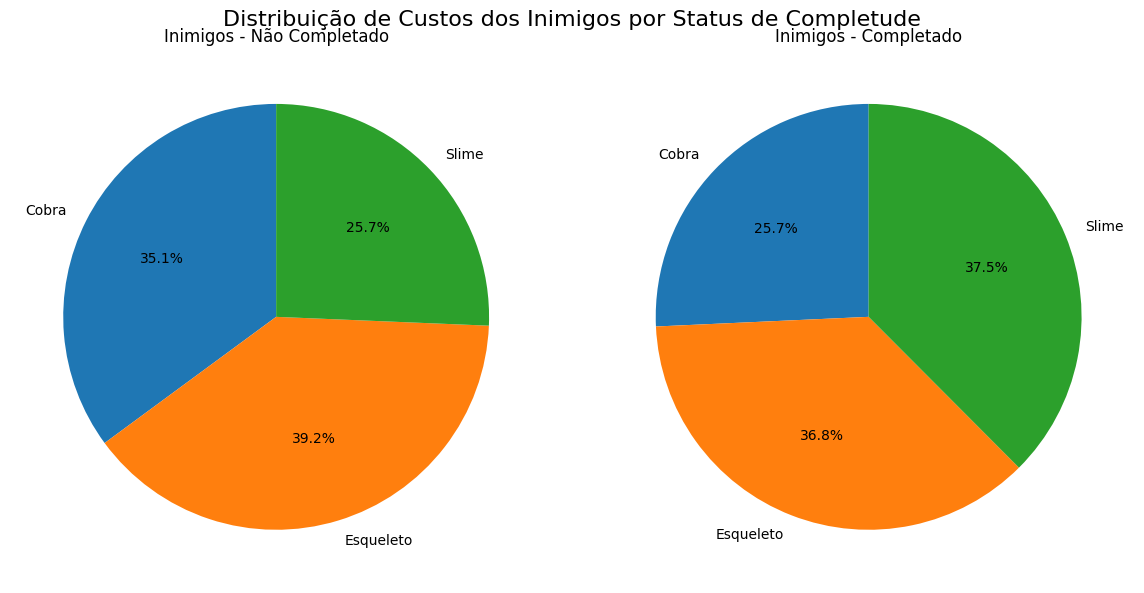

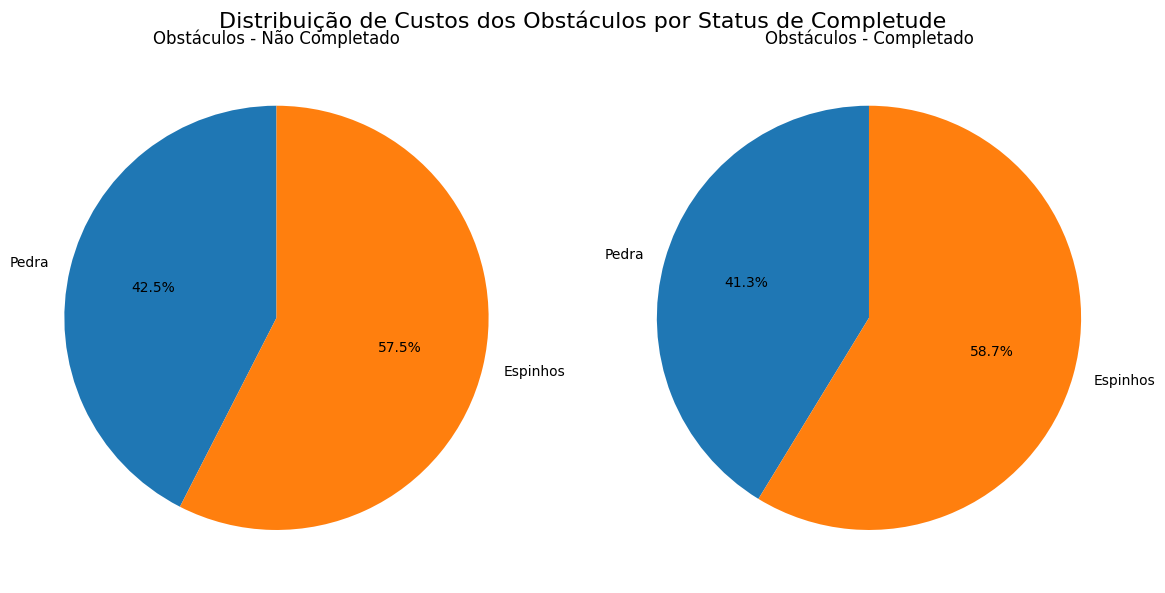

Completed    1.000000
Cobra       -0.095408
Esqueleto   -0.072129
Slime        0.156660
Pedra       -0.014769
Espinhos     0.014769
Name: Completed, dtype: float64


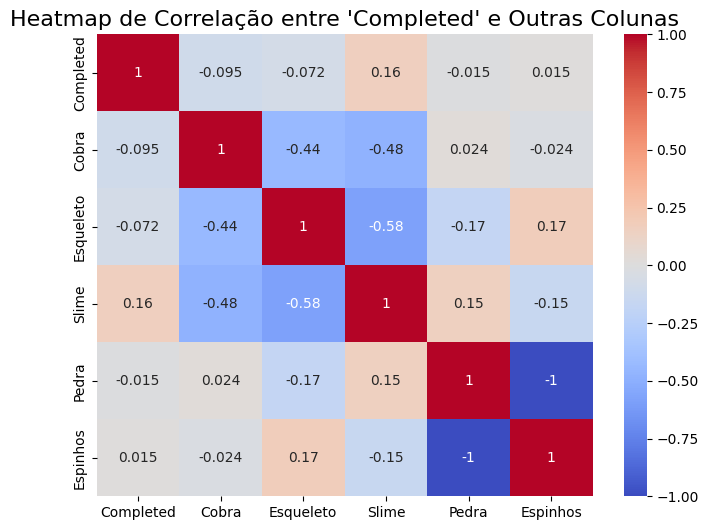

In [23]:
plot_object_costs(df_costs)

### Número de inimigos e obstáculos x feedback

In [24]:
def melt_data_by_completed(df, cols, new_col_name):
    return pd.melt(df, id_vars=['Completed'], value_vars=cols, var_name=new_col_name, value_name='Values')

result_data = []

for level in runs['level'].unique():
    df_filtered = runs[runs['level'] == level]
    for completed in df_filtered['is_completed'].unique():
        df_filtered_completed = df_filtered[df_filtered['is_completed'] == completed]
        for _, row in df_filtered_completed.iterrows():
            enemies = get_enemies_by_run_id(row['id'])
            obstacles = get_obstacles_by_run_id(row['id'])

            enemy_qnt = 0
            for _, row in enemies.iterrows():
                quantity = row['quantity']
                enemy_qnt += quantity

            obstacle_qnt = 0
            for _, row in obstacles.iterrows():
                quantity = row['quantity']
                obstacle_qnt += quantity

            result_data.append({
                'level': level,
                'Completed': completed,
                'EnemyQnt': enemy_qnt,
                'ObstacleQnt': obstacle_qnt
            })

df_object_qnt = pd.DataFrame(result_data)

#### Um plot por nível

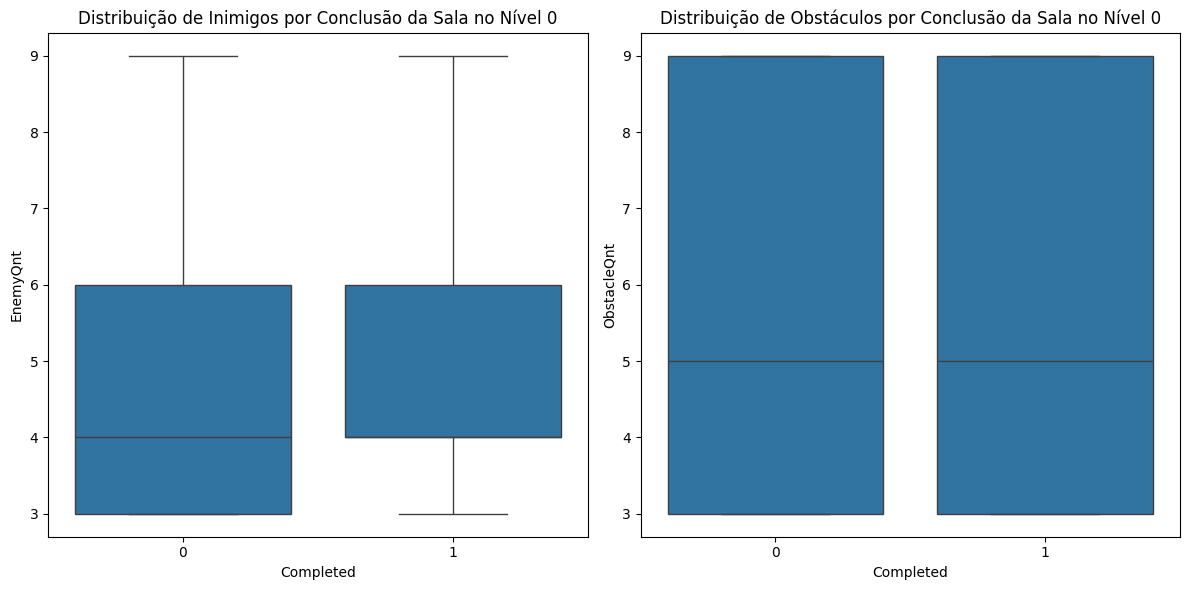

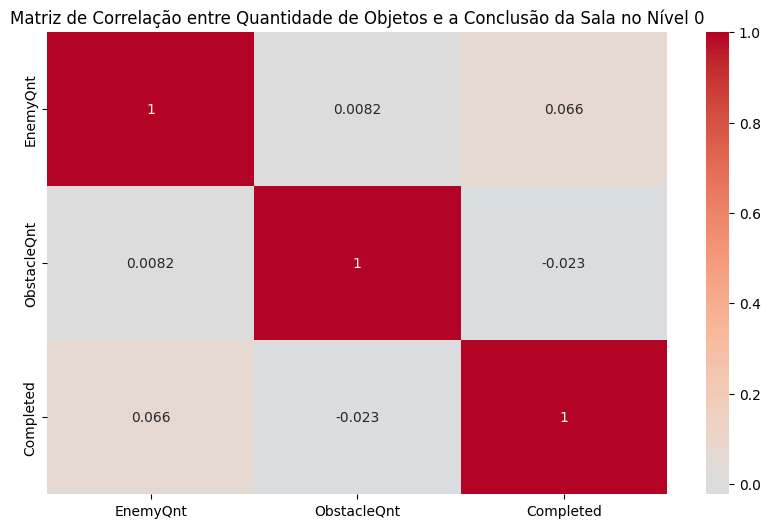

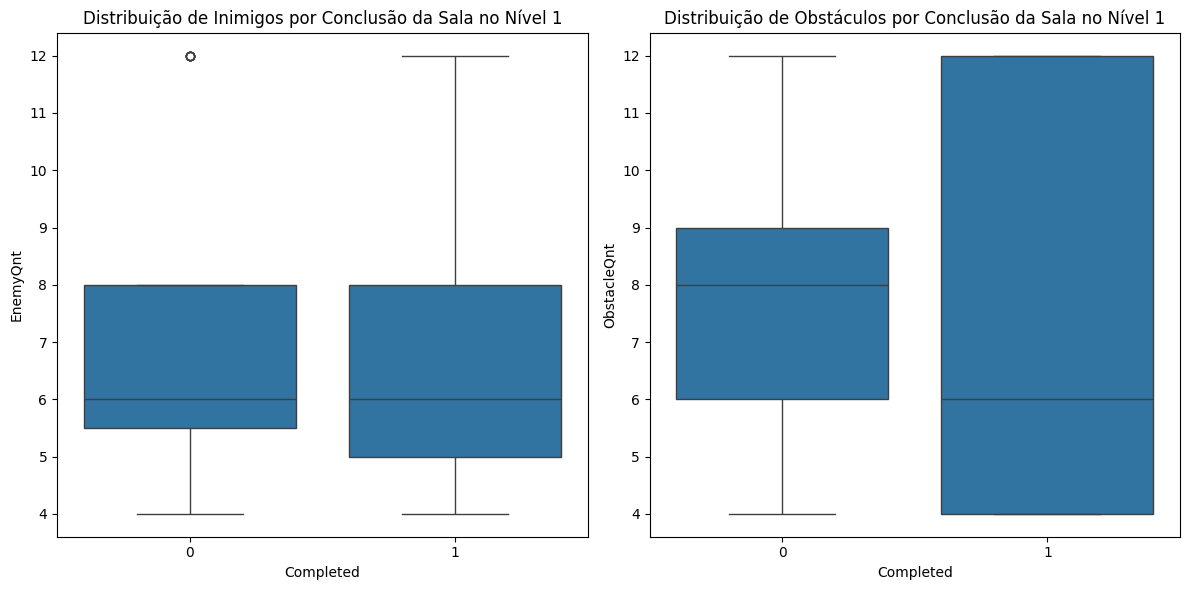

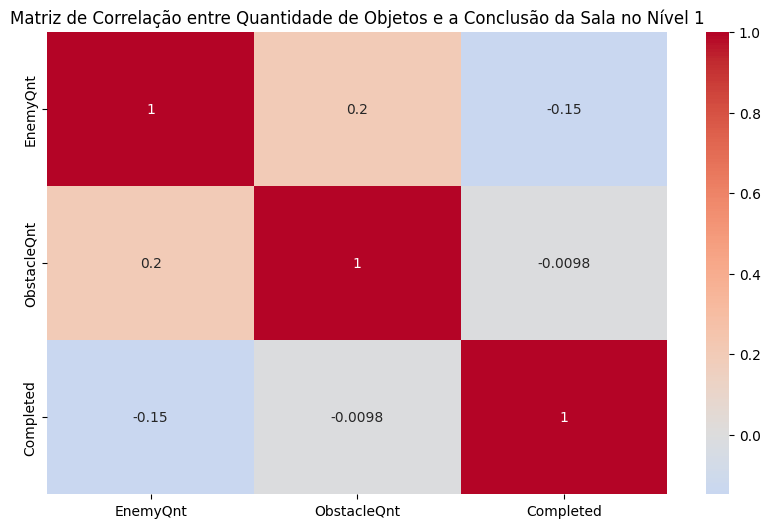

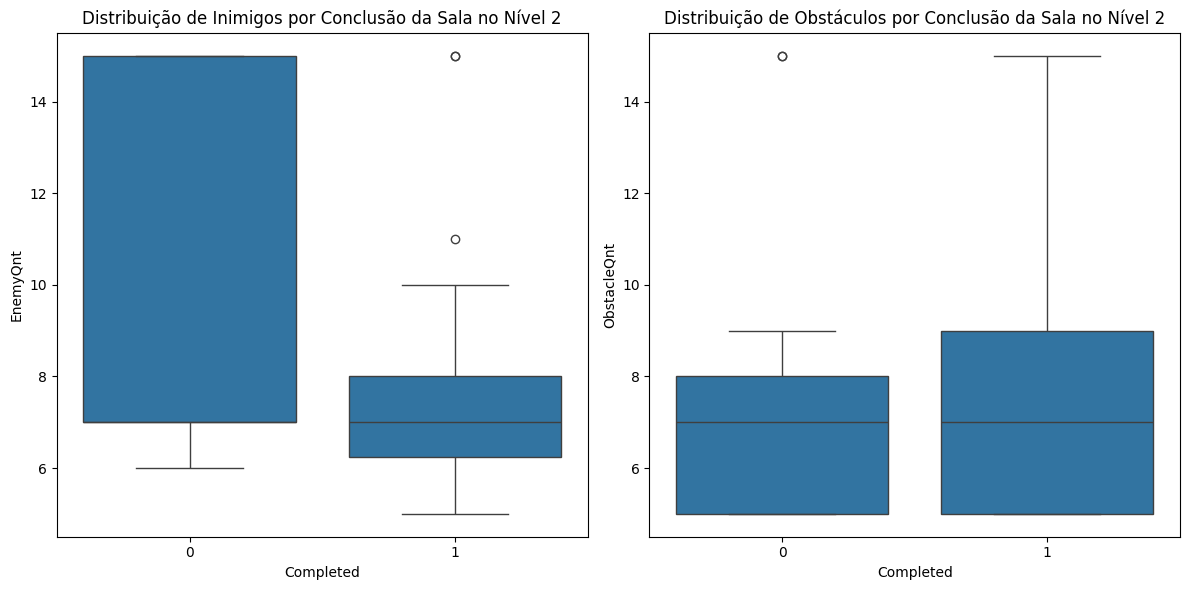

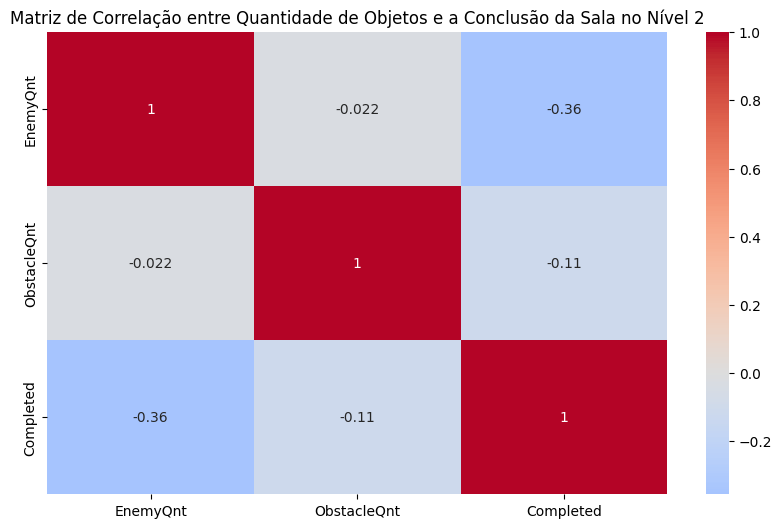

In [25]:
def melt_data_by_completed(df, cols, new_col_name):
    return pd.melt(df, id_vars=['Completed'], value_vars=cols, var_name=new_col_name, value_name='Values')

def plot_object_qnt(df, level=None):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    sns.boxplot(x='Completed', y='EnemyQnt', data=df)
    plt.title(f'Distribuição de Inimigos por Conclusão da Sala no Nível {level}')

    plt.subplot(1, 2, 2)
    sns.boxplot(x='Completed', y='ObstacleQnt', data=df)
    plt.title(f'Distribuição de Obstáculos por Conclusão da Sala no Nível {level}')

    plt.tight_layout()
    plt.show()

    correlation = df[['EnemyQnt', 'ObstacleQnt', 'Completed']].corr()
    plt.figure(figsize=(10, 6))
    sns.heatmap(correlation, annot=True, cmap='coolwarm', center=0)
    plt.title(f"Matriz de Correlação entre Quantidade de Objetos e a Conclusão da Sala no Nível {level}")
    plt.show()

plot_for_each_level(df_object_qnt, plot_object_qnt)

#### Tudo em um plot só

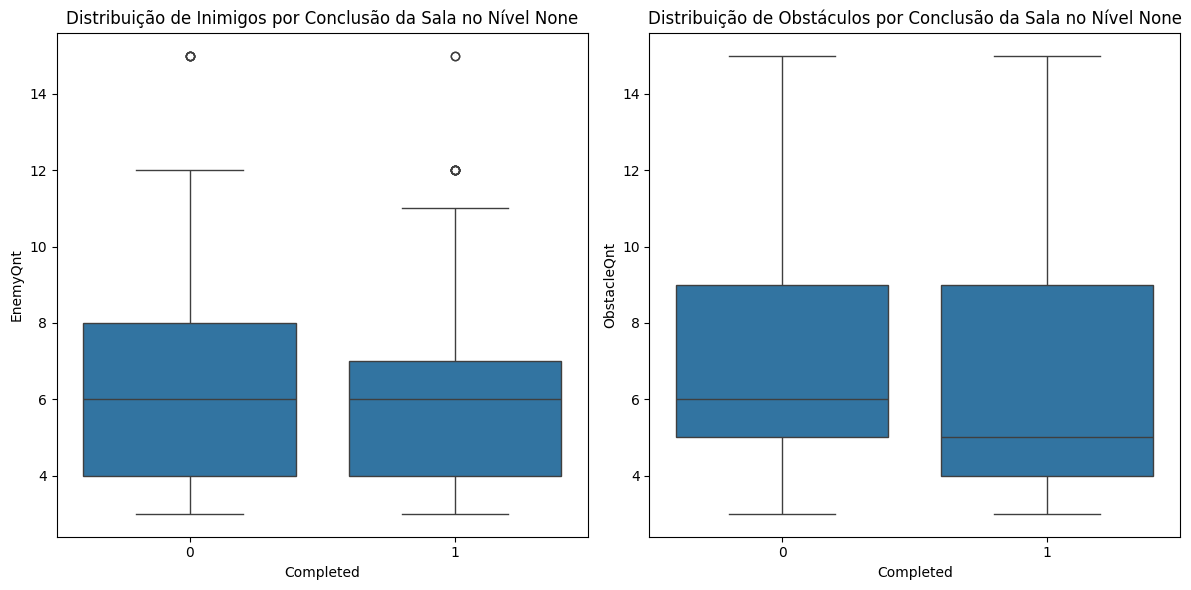

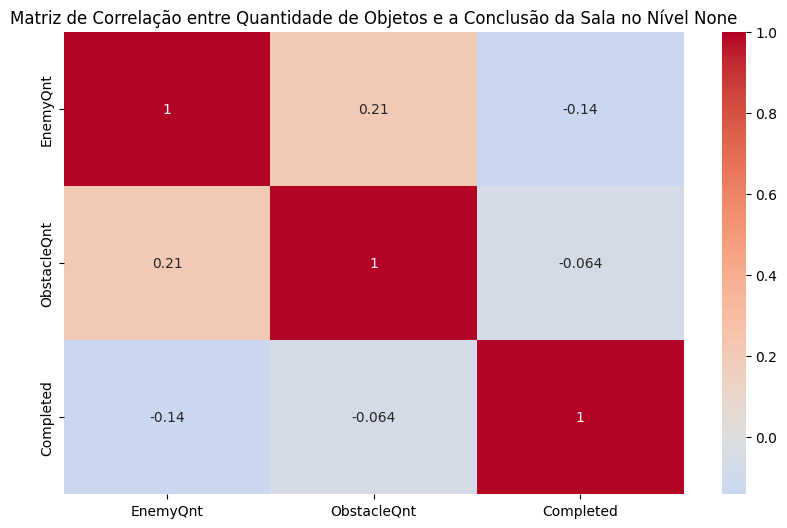

In [26]:
plot_object_qnt(df_object_qnt)